# Generate a plot of multiple SEDs

In [1]:
%load_ext autoreload
%autoreload 2

import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import syncfit

VLA_nus = np.linspace(0.11,50) #GHz
ALMA_nus = np.linspace(35, 950) # GHz

In [2]:
def row_to_val(row, key='Flux Density'):
    if '<' in row[key]:
        return float(row[key].replace(' ','')[1:])
    return float(row[key].split('+')[0])

def row_to_err(row, key='Flux Density'):
    if '<' in row[key]:
        return 0
    return float(row[key].split('-')[-1])

def is_upperlimit(row, key='Flux Density'):
    if '<' in row[key]:
        return True
    return False

def get_facility(row):
    if '-' in row['Array Configuration']:
        return 'ALMA'
    return 'VLA'

def label(row, obj_name):
    # if row.t < 100: # if the time is less than 100 days
    #     # this is an "early time" observation
    #     return obj_name+r' ($\Delta t < 100$ days)'
    return obj_name#+r' ($\Delta t > 100$ days)'

In [3]:
# First Sw J1644+57
SwJ1644_files = glob.glob('SwJ1644+57*')

allswfiles = []
cite_map = {'Berger2012':'Berger et al. (2012)',
            'Zauderer2013': 'Zauderer et al. (2013)',
            'Eftekhari2018': 'Eftekhari et al. (2018)'}
for f in SwJ1644_files:
    df = pd.read_csv(f, sep='\t') 
    for c in cite_map.keys():
        if c in f:
            df['Citation'] = [cite_map[c]]*len(df)
            continue

    allswfiles.append(df)
    
SwJ1644_data = pd.concat(allswfiles)
SwJ1644_data.Facility = SwJ1644_data.Facility.fillna('VLA') # all of these observations were with the VLA

# clean the data
del SwJ1644_data['Unnamed: 4']
del SwJ1644_data['Unnamed: 3']
SwJ1644_data = SwJ1644_data.drop(0)

SwJ1644_data['FluxDensity'] = SwJ1644_data.apply(row_to_val, axis=1)
SwJ1644_data['FluxDensityErr'] = SwJ1644_data.apply(row_to_err, axis=1)

del SwJ1644_data['Flux Density']

SwJ1644_data.Frequency = SwJ1644_data.Frequency.astype(float)
SwJ1644_data.t = SwJ1644_data.t.astype(float)


ts = SwJ1644_data.t.unique()
m, M = int(ts.min()), int(ts.max())

vals = np.logspace(np.log10(m),np.log10(M), 11, dtype=int)
SwJ1644_data['TimeGroup'] = np.zeros(len(SwJ1644_data))
SwJ1644_data['Object'] = SwJ1644_data.apply(label, obj_name='Sw J1644+57', axis=1)
for idx, row in SwJ1644_data.iterrows():
    
    for val_min, val_max in zip(vals[:-1], vals[1:]):
        if row.t >= val_min and row.t <= val_max:
            SwJ1644_data.TimeGroup[idx] = f'{val_min}-{val_max} days'
            break
            
SwJ1644_data['t'] = SwJ1644_data.t.astype(float)
SwJ1644_data

/tmp/ipykernel_13274/2284446150.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SwJ1644_data.TimeGroup[idx] = f'{val_min}-{val_max} days'
/tmp/ipykernel_13274/2284446150.py:44: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '143-273 days' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  SwJ1644_data.TimeGroup[idx] = f'{val_min}-{val_max} days'


,t,Facility,Frequency,Citation,FluxDensity,FluxDensityErr,TimeGroup,Object
1,244.23,JVLA,1.8,Zauderer et al. (2013),2.29,0.08,993-1894 days,Sw J1644+57
2,271.95,JVLA,1.8,Zauderer et al. (2013),2.02,0.23,993-1894 days,Sw J1644+57
3,383.92,JVLA,1.8,Zauderer et al. (2013),4.37,0.10,993-1894 days,Sw J1644+57
4,452.66,JVLA,1.8,Zauderer et al. (2013),3.77,0.09,993-1894 days,Sw J1644+57
5,581.31,JVLA,1.8,Zauderer et al. (2013),2.88,0.08,993-1894 days,Sw J1644+57
...,...,...,...,...,...,...,...,...
48,1029.00,VLA,24.5,Eftekhari et al. (2018),1.15,0.02,993-1894 days,Sw J1644+57
49,1093.00,VLA,24.5,Eftekhari et al. (2018),0.92,0.07,993-1894 days,Sw J1644+57
50,1890.00,VLA,24.5,Eftekhari et al. (2018),0.37,0.06,993-1894 days,Sw J1644+57
51,639.00,VLA,30.0,Eftekhari et al. (2018),1.88,0.09,521-993 days,Sw J1644+57


In [4]:
# Now AT2019dsg
dsg = pd.read_csv('AT2019dsg_Cendes2021.txt', sep=',')

dsg['FluxDensity'] = dsg.apply(row_to_val, axis=1)
dsg['FluxDensityErr'] = dsg.apply(row_to_err, axis=1)
dsg['Upperlimit'] = dsg.apply(is_upperlimit, axis=1)
dsg['Facility'] = dsg.apply(get_facility, axis=1)
dsg['Object'] = dsg.apply(label, obj_name='AT2019dsg', axis=1)

dsg['t'] = dsg.t.astype(float) 
dsg['Citation'] = ['Cendes et al. (2021)']*len(dsg)

dsg

,Date,t,Array Configuration,Frequency,Flux Density,FluxDensity,FluxDensityErr,Upperlimit,Facility,Object,Citation
0,2019 May 24,55.0,B,5.0,0.09 +or- 0.01,0.09,0.01,False,VLA,AT2019dsg,Cendes et al. (2021)
1,2019 May 24,55.0,B,7.0,0.19 +or- 0.01,0.19,0.01,False,VLA,AT2019dsg,Cendes et al. (2021)
2,2019 May 24,55.0,B,13.0,0.48 +or- 0.02,0.48,0.02,False,VLA,AT2019dsg,Cendes et al. (2021)
3,2019 May 24,55.0,B,15.0,0.54 +or- 0.02,0.54,0.02,False,VLA,AT2019dsg,Cendes et al. (2021)
4,2019 May 24,55.0,B,17.0,0.58 +or- 0.02,0.58,0.02,False,VLA,AT2019dsg,Cendes et al. (2021)
...,...,...,...,...,...,...,...,...,...,...,...
57,2020 Jan 24,300.0,D,17.0,0.23 +or- 0.03,0.23,0.03,False,VLA,AT2019dsg,Cendes et al. (2021)
58,2020 Oct 11,561.0,B,1.5,0.35 +or- 0.05,0.35,0.05,False,VLA,AT2019dsg,Cendes et al. (2021)
59,2020 Oct 11,561.0,B,2.6,0.26 +or- 0.02,0.26,0.02,False,VLA,AT2019dsg,Cendes et al. (2021)
60,2020 Oct 11,561.0,B,3.4,0.17 +or- 0.01,0.17,0.01,False,VLA,AT2019dsg,Cendes et al. (2021)


In [5]:
# AT2022cmc

cmc = pd.read_csv('AT2022cmc_Andreoni2022.txt', sep='&')

cmc = cmc.drop(0)
print(cmc[' nu '])
cmc['Frequency'] = cmc[' nu '].astype(float)#
cmc['t'] = cmc[' Delta t '].astype(float)
cmc['FluxDensity'] = cmc.apply(row_to_val, key=' F_nu ', axis=1).astype(float)*1e-3 # convert from uJy to mJy
cmc['FluxDensityErr'] = cmc['  RMS'].astype(float)*1e-3
cmc['Object'] = cmc.apply(label, obj_name='AT2022cmc', axis=1)
cmc['Citation'] = ['Andreoni et al. (2022)']*len(cmc)

cmc

1        8.5
2        9.5
3       10.5
4       11.5
5        8.5
       ...  
121     11.5
122     12.8
123     14.3
124     15.9
125     17.4
Name:  nu , Length: 125, dtype: object


,#Facility,UT date,Delta t,nu,F_nu,RMS,Frequency,t,FluxDensity,FluxDensityErr,Object,Citation
1,VLA,2022-02-15 12:30,4.07,8.5,33,7,8.5,4.07,0.033,0.007,AT2022cmc,Andreoni et al. (2022)
2,VLA,2022-02-15 12:30,4.07,9.5,46,7,9.5,4.07,0.046,0.007,AT2022cmc,Andreoni et al. (2022)
3,VLA,2022-02-15 12:30,4.07,10.5,51,8,10.5,4.07,0.051,0.008,AT2022cmc,Andreoni et al. (2022)
4,VLA,2022-02-15 12:30,4.07,11.5,68,9,11.5,4.07,0.068,0.009,AT2022cmc,Andreoni et al. (2022)
5,VLA,2022-02-16 12:19,5.07,8.5,43,8,8.5,5.07,0.043,0.008,AT2022cmc,Andreoni et al. (2022)
...,...,...,...,...,...,...,...,...,...,...,...,...
121,VLA,2022-03-31 04:13,47.73,11.5,438,14,11.5,47.73,0.438,0.014,AT2022cmc,Andreoni et al. (2022)
122,VLA,2022-03-31 04:23,47.74,12.8,583,12,12.8,47.74,0.583,0.012,AT2022cmc,Andreoni et al. (2022)
123,VLA,2022-03-31 04:23,47.74,14.3,724,12,14.3,47.74,0.724,0.012,AT2022cmc,Andreoni et al. (2022)
124,VLA,2022-03-31 04:23,47.74,15.9,801,14,15.9,47.74,0.801,0.014,AT2022cmc,Andreoni et al. (2022)


# Merge all the data and plot it

In [6]:
def sefd(nu, min_rms=1e-6, npol=1, dt=3600): 
    # from https://leo.phys.unm.edu/~lwa/obsstatus/obsstatus006.html
    return min_rms*np.sqrt(2*npol*nu*dt)*1e3 # calculate and convert from Jy -> mJy

In [7]:
data = pd.concat([SwJ1644_data, dsg, cmc])
data

,t,Facility,Frequency,Citation,FluxDensity,FluxDensityErr,TimeGroup,Object,Date,Array Configuration,Flux Density,Upperlimit,#Facility,UT date,Delta t,nu,F_nu,RMS
1,244.23,JVLA,1.8,Zauderer et al. (2013),2.290,0.080,993-1894 days,Sw J1644+57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,271.95,JVLA,1.8,Zauderer et al. (2013),2.020,0.230,993-1894 days,Sw J1644+57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,383.92,JVLA,1.8,Zauderer et al. (2013),4.370,0.100,993-1894 days,Sw J1644+57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,452.66,JVLA,1.8,Zauderer et al. (2013),3.770,0.090,993-1894 days,Sw J1644+57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,581.31,JVLA,1.8,Zauderer et al. (2013),2.880,0.080,993-1894 days,Sw J1644+57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,47.73,NaN,11.5,Andreoni et al. (2022),0.438,0.014,NaN,AT2022cmc,NaN,NaN,NaN,NaN,VLA,2022-03-31 04:13,47.73,11.5,438,14
122,47.74,NaN,12.8,Andreoni et al. (2022),0.583,0.012,NaN,AT2022cmc,NaN,NaN,NaN,NaN,VLA,2022-03-31 04:23,47.74,12.8,583,12
123,47.74,NaN,14.3,Andreoni et al. (2022),0.724,0.012,NaN,AT2022cmc,NaN,NaN,NaN,NaN,VLA,2022-03-31 04:23,47.74,14.3,724,12
124,47.74,NaN,15.9,Andreoni et al. (2022),0.801,0.014,NaN,AT2022cmc,NaN,NaN,NaN,NaN,VLA,2022-03-31 04:23,47.74,15.9,801,14


/tmp/ipykernel_12687/488859305.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avgs = grp.groupby('range').FluxDensity.agg(['min', 'max', 'median'])
/tmp/ipykernel_12687/488859305.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avgs = grp.groupby('range').FluxDensity.agg(['min', 'max', 'median'])
/tmp/ipykernel_12687/488859305.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avgs = grp.groupby('range').Flux

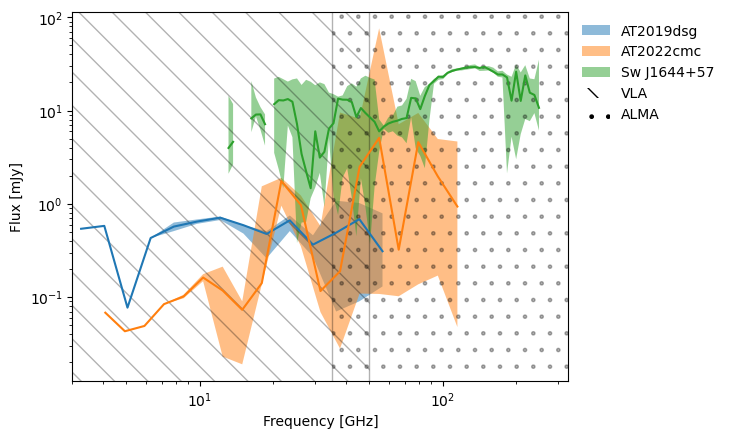

In [8]:
fig, ax = plt.subplots()
bin_factor = 3

for lab, grp in data.groupby('Object'):
    nbins = len(grp)//bin_factor
    bins = np.logspace(np.log10(grp.Frequency.min()), np.log10(grp.Frequency.max()), nbins)
    grp['range'] = pd.cut(grp.index, 
                          bins, 
                          retbins=False)
    avgs = grp.groupby('range').FluxDensity.agg(['min', 'max', 'median'])
    bincenter = list(avgs.index.map(lambda interval: (interval.left+interval.right)/2))
    
    # plot a 2 std region
    ax.fill_between(bincenter, avgs['min'], avgs['max'], alpha=0.5, label=lab)
    ax.plot(bincenter, avgs['median'])

ax.set_xscale('log')
ax.set_yscale('log')
xlim = ax.get_xlim()
ylim = ax.get_ylim()
    
ax.fill_between(VLA_nus, [1e-50]*len(VLA_nus), [1000]*len(VLA_nus), label='VLA', alpha=0.3, facecolor="none", hatch="\\")
ax.fill_between(ALMA_nus, [1e-50]*len(ALMA_nus), [1000]*len(ALMA_nus), label='ALMA', alpha=0.3, facecolor="none", hatch=".",)

ax.set_ylim(*ylim)
ax.set_xlim(3, xlim[1])
ax.set_ylabel('Flux [mJy]')
ax.set_xlabel('Frequency [GHz]')
ax.legend(bbox_to_anchor=(1.32, 1), frameon=False,)

fig.savefig('SEFD-plot.png', transparent=False, bbox_inches='tight')

In [9]:
data

,t,Facility,Frequency,Citation,FluxDensity,FluxDensityErr,TimeGroup,Object,Date,Array Configuration,Flux Density,Upperlimit,#Facility,UT date,Delta t,nu,F_nu,RMS
1,244.23,JVLA,1.8,Zauderer et al. (2013),2.290,0.080,993-1894 days,Sw J1644+57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,271.95,JVLA,1.8,Zauderer et al. (2013),2.020,0.230,993-1894 days,Sw J1644+57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,383.92,JVLA,1.8,Zauderer et al. (2013),4.370,0.100,993-1894 days,Sw J1644+57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,452.66,JVLA,1.8,Zauderer et al. (2013),3.770,0.090,993-1894 days,Sw J1644+57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,581.31,JVLA,1.8,Zauderer et al. (2013),2.880,0.080,993-1894 days,Sw J1644+57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,47.73,NaN,11.5,Andreoni et al. (2022),0.438,0.014,NaN,AT2022cmc,NaN,NaN,NaN,NaN,VLA,2022-03-31 04:13,47.73,11.5,438,14
122,47.74,NaN,12.8,Andreoni et al. (2022),0.583,0.012,NaN,AT2022cmc,NaN,NaN,NaN,NaN,VLA,2022-03-31 04:23,47.74,12.8,583,12
123,47.74,NaN,14.3,Andreoni et al. (2022),0.724,0.012,NaN,AT2022cmc,NaN,NaN,NaN,NaN,VLA,2022-03-31 04:23,47.74,14.3,724,12
124,47.74,NaN,15.9,Andreoni et al. (2022),0.801,0.014,NaN,AT2022cmc,NaN,NaN,NaN,NaN,VLA,2022-03-31 04:23,47.74,15.9,801,14


# Model the SEDs

  0%|                                                                        | 0/100 [00:00<?, ?it/s]

  3%|█▉                                                              | 3/100 [00:00<00:03, 27.17it/s]

  6%|███▊                                                            | 6/100 [00:00<00:03, 27.53it/s]

  9%|█████▊                                                          | 9/100 [00:00<00:03, 27.63it/s]

 12%|███████▌                                                       | 12/100 [00:00<00:03, 27.62it/s]

 15%|█████████▍                                                     | 15/100 [00:00<00:03, 27.76it/s]

 18%|███████████▎                                                   | 18/100 [00:00<00:02, 27.91it/s]

 21%|█████████████▏                                                 | 21/100 [00:00<00:02, 28.31it/s]

 25%|███████████████▊                                               | 25/100 [00:00<00:02, 29.28it/s]

 29%|██████████████████▎                                            | 29/100 [00:01<00:02, 30.23it/s]

 33%|████████████████████▊                                          | 33/100 [00:01<00:02, 31.70it/s]

 37%|███████████████████████▎                                       | 37/100 [00:01<00:01, 32.97it/s]

 41%|█████████████████████████▊                                     | 41/100 [00:01<00:01, 33.71it/s]

 45%|████████████████████████████▎                                  | 45/100 [00:01<00:01, 35.12it/s]

 49%|██████████████████████████████▊                                | 49/100 [00:01<00:01, 35.11it/s]

 53%|█████████████████████████████████▍                             | 53/100 [00:01<00:01, 35.49it/s]

 57%|███████████████████████████████████▉                           | 57/100 [00:01<00:01, 35.62it/s]

 61%|██████████████████████████████████████▍                        | 61/100 [00:01<00:01, 35.79it/s]

 65%|████████████████████████████████████████▉                      | 65/100 [00:02<00:01, 34.80it/s]

 69%|███████████████████████████████████████████▍                   | 69/100 [00:02<00:00, 34.71it/s]

 73%|█████████████████████████████████████████████▉                 | 73/100 [00:02<00:00, 34.33it/s]

 77%|████████████████████████████████████████████████▌              | 77/100 [00:02<00:00, 34.15it/s]

 81%|███████████████████████████████████████████████████            | 81/100 [00:02<00:00, 34.39it/s]

 85%|█████████████████████████████████████████████████████▌         | 85/100 [00:02<00:00, 33.02it/s]

 89%|████████████████████████████████████████████████████████       | 89/100 [00:02<00:00, 33.31it/s]

 93%|██████████████████████████████████████████████████████████▌    | 93/100 [00:02<00:00, 33.89it/s]

 97%|█████████████████████████████████████████████████████████████  | 97/100 [00:02<00:00, 33.96it/s]

100%|██████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 32.78it/s]

  0%|                                                                        | 0/100 [00:00<?, ?it/s]

  3%|█▉                                                              | 3/100 [00:00<00:03, 27.30it/s]

  6%|███▊                                                            | 6/100 [00:00<00:03, 27.24it/s]

  9%|█████▊                                                          | 9/100 [00:00<00:03, 27.19it/s]

 12%|███████▌                                                       | 12/100 [00:00<00:03, 27.20it/s]

 15%|█████████▍                                                     | 15/100 [00:00<00:03, 27.22it/s]

 18%|███████████▎                                                   | 18/100 [00:00<00:02, 27.40it/s]

 21%|█████████████▏                                                 | 21/100 [00:00<00:02, 27.94it/s]

 24%|███████████████                                                | 24/100 [00:00<00:02, 28.45it/s]

 28%|█████████████████▋                                             | 28/100 [00:00<00:02, 29.19it/s]

 32%|████████████████████▏                                          | 32/100 [00:01<00:02, 30.49it/s]

 36%|██████████████████████▋                                        | 36/100 [00:01<00:02, 31.29it/s]

 40%|█████████████████████████▏                                     | 40/100 [00:01<00:01, 31.70it/s]

 44%|███████████████████████████▋                                   | 44/100 [00:01<00:01, 32.23it/s]

 48%|██████████████████████████████▏                                | 48/100 [00:01<00:01, 31.62it/s]

 52%|████████████████████████████████▊                              | 52/100 [00:01<00:01, 31.18it/s]

 56%|███████████████████████████████████▎                           | 56/100 [00:01<00:01, 31.09it/s]

 60%|█████████████████████████████████████▊                         | 60/100 [00:02<00:01, 31.04it/s]

 64%|████████████████████████████████████████▎                      | 64/100 [00:02<00:01, 30.62it/s]

 68%|██████████████████████████████████████████▊                    | 68/100 [00:02<00:01, 30.49it/s]

 72%|█████████████████████████████████████████████▎                 | 72/100 [00:02<00:00, 30.63it/s]

 76%|███████████████████████████████████████████████▉               | 76/100 [00:02<00:00, 30.86it/s]

 80%|██████████████████████████████████████████████████▍            | 80/100 [00:02<00:00, 30.65it/s]

 84%|████████████████████████████████████████████████████▉          | 84/100 [00:02<00:00, 30.78it/s]

 88%|███████████████████████████████████████████████████████▍       | 88/100 [00:02<00:00, 30.86it/s]

 92%|█████████████████████████████████████████████████████████▉     | 92/100 [00:03<00:00, 30.81it/s]

 96%|████████████████████████████████████████████████████████████▍  | 96/100 [00:03<00:00, 30.55it/s]

100%|██████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.39it/s]

100%|██████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.19it/s]

  0%|                                                                        | 0/100 [00:00<?, ?it/s]

  3%|█▉                                                              | 3/100 [00:00<00:03, 25.94it/s]

  6%|███▊                                                            | 6/100 [00:00<00:03, 25.80it/s]

  9%|█████▊                                                          | 9/100 [00:00<00:03, 25.78it/s]

 12%|███████▌                                                       | 12/100 [00:00<00:03, 25.87it/s]

 15%|█████████▍                                                     | 15/100 [00:00<00:03, 25.93it/s]

 18%|███████████▎                                                   | 18/100 [00:00<00:03, 26.18it/s]

 21%|█████████████▏                                                 | 21/100 [00:00<00:03, 26.33it/s]

 24%|███████████████                                                | 24/100 [00:00<00:02, 27.11it/s]

 27%|█████████████████                                              | 27/100 [00:01<00:02, 27.72it/s]

 31%|███████████████████▌                                           | 31/100 [00:01<00:02, 29.00it/s]

 35%|██████████████████████                                         | 35/100 [00:01<00:02, 29.88it/s]

 39%|████████████████████████▌                                      | 39/100 [00:01<00:01, 30.87it/s]

 43%|███████████████████████████                                    | 43/100 [00:01<00:01, 32.65it/s]

 47%|█████████████████████████████▌                                 | 47/100 [00:01<00:01, 33.20it/s]

 51%|████████████████████████████████▏                              | 51/100 [00:01<00:01, 33.12it/s]

 55%|██████████████████████████████████▋                            | 55/100 [00:01<00:01, 33.58it/s]

 59%|█████████████████████████████████████▏                         | 59/100 [00:01<00:01, 33.65it/s]

 63%|███████████████████████████████████████▋                       | 63/100 [00:02<00:01, 33.05it/s]

 67%|██████████████████████████████████████████▏                    | 67/100 [00:02<00:01, 32.79it/s]

 71%|████████████████████████████████████████████▋                  | 71/100 [00:02<00:00, 32.16it/s]

 75%|███████████████████████████████████████████████▎               | 75/100 [00:02<00:00, 31.78it/s]

 79%|█████████████████████████████████████████████████▊             | 79/100 [00:02<00:00, 31.27it/s]

 83%|████████████████████████████████████████████████████▎          | 83/100 [00:02<00:00, 31.14it/s]

 87%|██████████████████████████████████████████████████████▊        | 87/100 [00:02<00:00, 31.17it/s]

 91%|█████████████████████████████████████████████████████████▎     | 91/100 [00:02<00:00, 31.19it/s]

 95%|███████████████████████████████████████████████████████████▊   | 95/100 [00:03<00:00, 30.82it/s]

 99%|██████████████████████████████████████████████████████████████▎| 99/100 [00:03<00:00, 30.81it/s]

100%|██████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.40it/s]

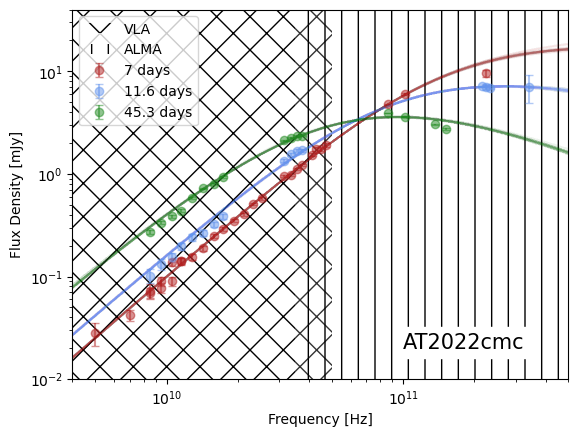

In [10]:
import syncfit

centervals = [7, 11.6, 45.3]
tols = [1, 0.5, 5]
theta_inits = [3, 1, 10, 11]
n = 100
burnin = n//2
model = syncfit.models.B1B2
nkeep = 100
cols = ['firebrick', 'cornflowerblue', 'forestgreen']

fig, ax = plt.subplots()

for val, tol, c in zip(centervals, tols, cols):

    ds = cmc[np.isclose(cmc.t, val, atol=tol)]
    ds = ds[ds.Frequency > 3]
    
    lines = ax.errorbar(1e9*ds.Frequency, ds.FluxDensity, fmt='o', yerr=ds.FluxDensityErr, 
                label=f'{val} days', alpha=0.5, capsize=3, color=c)
    
    
    # with mm data
    sampler = syncfit.do_emcee(theta_inits, ds.Frequency.astype(float), ds.FluxDensity*1e3, 
                                ds.FluxDensityErr*1e3, plot=False, niter=n, model=model)
    out, log_prob = syncfit.analysis.extract_output(sampler)
    nus = np.arange(1e8,5e12,1e7)  
    sed = model.SED
    best = out[np.argsort(log_prob)[-nkeep:]]
    for o in best:
        res = sed(nus, *o)
        ax.plot(nus, res, alpha=0.01, linestyle='-', color=lines[-1][0].get_color())
    
ax.set_ylabel(r'Flux Density [mJy]')
ax.set_xlabel('Frequency [Hz]')
ax.set_yscale('log')
ax.set_xscale('log')
ax.text(1e11, 2e-2, 'AT2022cmc', fontsize=15, backgroundcolor='w')
ax.set_ylim(1e-2, 4e1)
ax.set_xlim(4e9, 5e11)

ax.fill_between(VLA_nus*1e9, [1e-50]*len(VLA_nus), [1000]*len(VLA_nus), label='VLA', alpha=0.2, facecolor='w', hatch="x")
ax.fill_between(ALMA_nus*1e9, [1e-50]*len(ALMA_nus), [1000]*len(ALMA_nus), label='ALMA', alpha=0.2, facecolor="w", hatch="|",)

ax.legend()

fig.savefig('2022cmc-sed-plot.png', transparent=False, bbox_inches='tight')

# AT2019dsg

In [10]:
class CustomB5B3(syncfit.models.B5B3):
    
    # We just need to update the smoothing parameters here!
    
    def SED2(nu, p, log_F_nu, log_nu_a, log_nu_c):
        b1 = 2
        b2 = 5/2
        b3 = (1-p)/2
        b4 = -p/2

        s1 = 3.63*p-1.6
        s2 = 1.25-0.18*p
        s3 = 10

        F_nu = 10**log_F_nu
        nu_m = 0.1*1e9
        nu_a = 10**log_nu_a
        nu_c = 10**log_nu_c


        term1 = ( (nu/nu_m)**(b1) * np.exp(-s1*(nu/nu_m)**(2/3)) + (nu/nu_m)**(b2))
        term2 = ( 1 + (nu/nu_a)**(s2*(b2-b3)) )**(-1/s2)
        term3 = ( 1 + (nu/nu_c)**(s3*(b3-b4)) )**(-1/s3)
        
        return F_nu * term1 * term2 * term3

    def SED(nu, p, log_F_nu, log_nu_a, log_nu_c):
        b1 = 5/2
        b2 = (1-p)/2
        b3 = -p/2

        s12 = 1.25-0.18*p
        s23 = 10 #1.15-0.06*p

        F_nu = 10**log_F_nu
        nu_c = 10**log_nu_c
        nu_a = 10**log_nu_a

        term1 = ((nu/nu_a)**(-s12*b1) + (nu/nu_a)**(-s12*b2))**(-1/s12)
        term2 = (1 + (nu/nu_c)**(s23*(b2-b3)))**(-1/s23)

        return F_nu * term1 * term2
    
    def lnprior(theta, p=None, **kwargs):
        ''' Priors: '''
        if p is None:
            p, log_F_nu, log_nu_a, log_nu_c = theta
        else:
            log_F_nu, log_nu_a, log_nu_c = theta

        if 2 < p < 4 and -1 < log_F_nu < 1 and 9 < log_nu_a < 10.35 and 10.35 < log_nu_c < 10.5:
            return 0.0

        else:
            return -np.inf
    
class CustomB5(syncfit.models.B5):
        
    def lnprior(theta, p=None, **kwargs):
        ''' Priors: '''
        if p is None:
            p, log_F_nu, log_nu_a = theta
        else:
            log_F_nu, log_nu_a = theta

        if 2 < p < 4 and -1 < log_F_nu < 1 and 9 < log_nu_a < 11:
            return 0.0

        else:
            return -np.inf


In [11]:
ds = dsg[np.isclose(dsg.t, 83, atol=2)]
import syncfit

In [12]:
10**10.4 / 1e9

25.11886431509582

  0%|                                                                        | 0/500 [00:00<?, ?it/s]

  2%|█                                                               | 8/500 [00:00<00:06, 77.59it/s]

  4%|██▎                                                            | 18/500 [00:00<00:05, 85.97it/s]

  6%|███▌                                                           | 28/500 [00:00<00:05, 89.79it/s]

  8%|████▊                                                          | 38/500 [00:00<00:05, 91.72it/s]

 10%|██████                                                         | 48/500 [00:00<00:04, 94.32it/s]

 12%|███████▎                                                       | 58/500 [00:00<00:04, 94.48it/s]

 14%|████████▌                                                      | 68/500 [00:00<00:04, 92.02it/s]

 16%|█████████▊                                                     | 78/500 [00:00<00:04, 90.24it/s]

 18%|███████████                                                    | 88/500 [00:00<00:04, 88.87it/s]

 19%|████████████▏                                                  | 97/500 [00:01<00:04, 87.95it/s]

 21%|█████████████▏                                                | 106/500 [00:01<00:04, 87.36it/s]

 23%|██████████████▎                                               | 115/500 [00:01<00:04, 87.60it/s]

 25%|███████████████▍                                              | 124/500 [00:01<00:04, 87.94it/s]

 27%|████████████████▍                                             | 133/500 [00:01<00:04, 87.48it/s]

 29%|█████████████████▋                                            | 143/500 [00:01<00:03, 89.28it/s]

 31%|██████████████████▉                                           | 153/500 [00:01<00:03, 90.09it/s]

 33%|████████████████████▏                                         | 163/500 [00:01<00:03, 90.54it/s]

 35%|█████████████████████▍                                        | 173/500 [00:01<00:03, 90.90it/s]

 37%|██████████████████████▋                                       | 183/500 [00:02<00:03, 91.99it/s]

 39%|███████████████████████▉                                      | 193/500 [00:02<00:03, 91.03it/s]

 41%|█████████████████████████▏                                    | 203/500 [00:02<00:03, 90.69it/s]

 43%|██████████████████████████▍                                   | 213/500 [00:02<00:03, 90.59it/s]

 45%|███████████████████████████▋                                  | 223/500 [00:02<00:03, 90.21it/s]

 47%|████████████████████████████▉                                 | 233/500 [00:02<00:02, 92.11it/s]

 49%|██████████████████████████████▏                               | 243/500 [00:02<00:02, 90.95it/s]

 51%|███████████████████████████████▎                              | 253/500 [00:02<00:02, 91.01it/s]

 53%|████████████████████████████████▌                             | 263/500 [00:02<00:02, 90.76it/s]

 55%|█████████████████████████████████▊                            | 273/500 [00:03<00:02, 91.94it/s]

 57%|███████████████████████████████████                           | 283/500 [00:03<00:02, 90.58it/s]

 59%|████████████████████████████████████▎                         | 293/500 [00:03<00:02, 89.73it/s]

 60%|█████████████████████████████████████▍                        | 302/500 [00:03<00:02, 89.22it/s]

 62%|██████████████████████████████████████▌                       | 311/500 [00:03<00:02, 88.81it/s]

 64%|███████████████████████████████████████▊                      | 321/500 [00:03<00:02, 89.42it/s]

 66%|█████████████████████████████████████████                     | 331/500 [00:03<00:01, 89.94it/s]

 68%|██████████████████████████████████████████▏                   | 340/500 [00:03<00:01, 89.50it/s]

 70%|███████████████████████████████████████████▎                  | 349/500 [00:03<00:01, 89.20it/s]

 72%|████████████████████████████████████████████▍                 | 358/500 [00:03<00:01, 88.91it/s]

 73%|█████████████████████████████████████████████▌                | 367/500 [00:04<00:01, 88.48it/s]

 75%|██████████████████████████████████████████████▋               | 377/500 [00:04<00:01, 89.50it/s]

 77%|███████████████████████████████████████████████▉              | 387/500 [00:04<00:01, 90.39it/s]

 79%|█████████████████████████████████████████████████▏            | 397/500 [00:04<00:01, 89.92it/s]

 81%|██████████████████████████████████████████████████▍           | 407/500 [00:04<00:01, 90.37it/s]

 83%|███████████████████████████████████████████████████▋          | 417/500 [00:04<00:00, 90.00it/s]

 85%|████████████████████████████████████████████████████▉         | 427/500 [00:04<00:00, 90.55it/s]

 87%|██████████████████████████████████████████████████████▏       | 437/500 [00:04<00:00, 91.26it/s]

 89%|███████████████████████████████████████████████████████▍      | 447/500 [00:04<00:00, 90.34it/s]

 91%|████████████████████████████████████████████████████████▋     | 457/500 [00:05<00:00, 90.11it/s]

 93%|█████████████████████████████████████████████████████████▉    | 467/500 [00:05<00:00, 90.39it/s]

 95%|███████████████████████████████████████████████████████████▏  | 477/500 [00:05<00:00, 90.02it/s]

 97%|████████████████████████████████████████████████████████████▍ | 487/500 [00:05<00:00, 90.44it/s]

 99%|█████████████████████████████████████████████████████████████▋| 497/500 [00:05<00:00, 89.60it/s]

100%|██████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 90.00it/s]

Best fit values for day:  None
\mathrm{log F_v} = 1.99e-01_{-0.068}^{0.006}
\mathrm{log nu_a} = 9.92e+00_{-0.009}^{0.034}
\mathrm{log nu_c} = 1.04e+01_{-0.010}^{0.034}


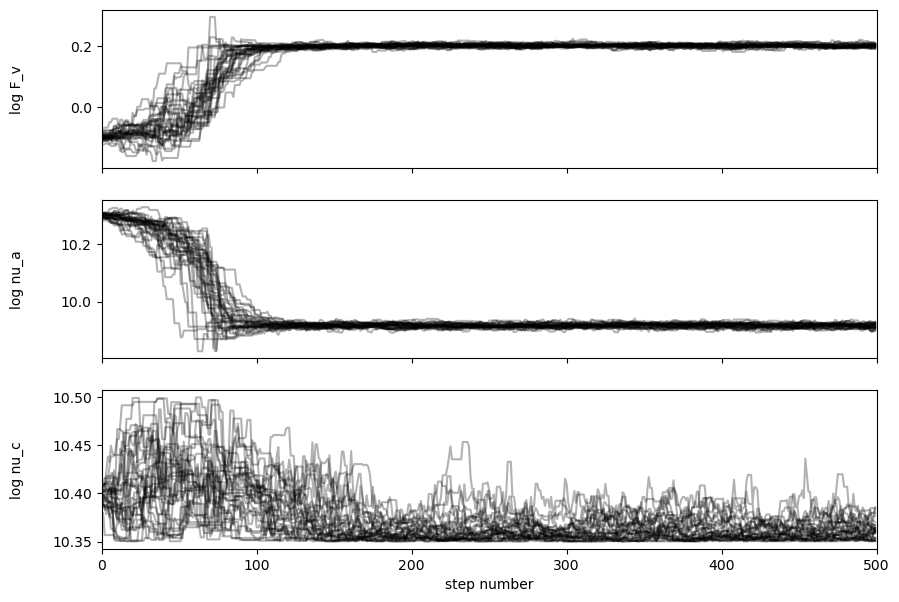

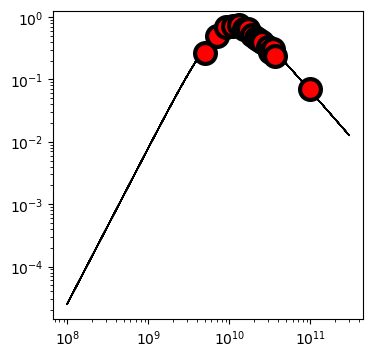

In [14]:
# try to fit the data
theta_inits = [-0.1,10.3,10.4]
n = 500
model = CustomB5B3 #syncfit.models.B5B3
p = 2.97
# p = syncfit.analysis.get_bounds(sampler, labels=['p', 'log F_v', 'log nu_a', 'log nu_c'], discard=1000)[0][0]

F_uJy = ds.FluxDensity*1e3
F_err_uJy = ds.FluxDensityErr*1e3

sampler = syncfit.do_emcee(theta_inits, ds.Frequency, F_uJy, F_err_uJy, 
                                plot=True, niter=n, model=model, nwalkers=32, fix_p=p)

out, log_prob = syncfit.analysis.extract_output(sampler)

  0%|                                                                        | 0/500 [00:00<?, ?it/s]

  2%|█▍                                                            | 12/500 [00:00<00:04, 115.94it/s]

  5%|██▉                                                           | 24/500 [00:00<00:04, 115.82it/s]

  7%|████▍                                                         | 36/500 [00:00<00:04, 115.43it/s]

 10%|█████▉                                                        | 48/500 [00:00<00:03, 114.68it/s]

 12%|███████▍                                                      | 60/500 [00:00<00:03, 114.61it/s]

 14%|████████▉                                                     | 72/500 [00:00<00:03, 113.81it/s]

 17%|██████████▍                                                   | 84/500 [00:00<00:03, 113.74it/s]

 19%|███████████▉                                                  | 96/500 [00:00<00:03, 113.48it/s]

 22%|█████████████▏                                               | 108/500 [00:00<00:03, 113.76it/s]

 24%|██████████████▋                                              | 120/500 [00:01<00:03, 113.51it/s]

 26%|████████████████                                             | 132/500 [00:01<00:03, 113.35it/s]

 29%|█████████████████▌                                           | 144/500 [00:01<00:03, 113.25it/s]

 31%|███████████████████                                          | 156/500 [00:01<00:03, 113.12it/s]

 34%|████████████████████▍                                        | 168/500 [00:01<00:02, 112.98it/s]

 36%|█████████████████████▉                                       | 180/500 [00:01<00:02, 112.96it/s]

 38%|███████████████████████▍                                     | 192/500 [00:01<00:02, 112.97it/s]

 41%|████████████████████████▉                                    | 204/500 [00:01<00:02, 113.03it/s]

 43%|██████████████████████████▎                                  | 216/500 [00:01<00:02, 112.92it/s]

 46%|███████████████████████████▊                                 | 228/500 [00:02<00:02, 112.76it/s]

 48%|█████████████████████████████▎                               | 240/500 [00:02<00:02, 112.81it/s]

 50%|██████████████████████████████▋                              | 252/500 [00:02<00:02, 112.71it/s]

 53%|████████████████████████████████▏                            | 264/500 [00:02<00:02, 112.81it/s]

 55%|█████████████████████████████████▋                           | 276/500 [00:02<00:01, 112.66it/s]

 58%|███████████████████████████████████▏                         | 288/500 [00:02<00:01, 112.74it/s]

 60%|████████████████████████████████████▌                        | 300/500 [00:02<00:01, 112.83it/s]

 62%|██████████████████████████████████████                       | 312/500 [00:02<00:01, 114.14it/s]

 65%|███████████████████████████████████████▌                     | 324/500 [00:02<00:01, 109.33it/s]

 67%|████████████████████████████████████████▉                    | 336/500 [00:02<00:01, 110.49it/s]

 70%|██████████████████████████████████████████▍                  | 348/500 [00:03<00:01, 111.22it/s]

 72%|███████████████████████████████████████████▉                 | 360/500 [00:03<00:01, 111.57it/s]

 74%|█████████████████████████████████████████████▍               | 372/500 [00:03<00:01, 111.88it/s]

 77%|██████████████████████████████████████████████▊              | 384/500 [00:03<00:01, 112.09it/s]

 79%|████████████████████████████████████████████████▎            | 396/500 [00:03<00:00, 112.46it/s]

 82%|█████████████████████████████████████████████████▊           | 408/500 [00:03<00:00, 112.67it/s]

 84%|███████████████████████████████████████████████████▏         | 420/500 [00:03<00:00, 112.65it/s]

 86%|████████████████████████████████████████████████████▋        | 432/500 [00:03<00:00, 112.92it/s]

 89%|██████████████████████████████████████████████████████▏      | 444/500 [00:03<00:00, 113.35it/s]

 91%|███████████████████████████████████████████████████████▋     | 456/500 [00:04<00:00, 113.84it/s]

 94%|█████████████████████████████████████████████████████████    | 468/500 [00:04<00:00, 113.80it/s]

 96%|██████████████████████████████████████████████████████████▌  | 480/500 [00:04<00:00, 113.62it/s]

 98%|████████████████████████████████████████████████████████████ | 492/500 [00:04<00:00, 113.65it/s]

100%|█████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 113.04it/s]

Best fit values for day:  None
\mathrm{log F_v} = 1.89e-01_{-0.009}^{0.006}
\mathrm{log nu_a} = 9.90e+00_{-0.009}^{0.011}


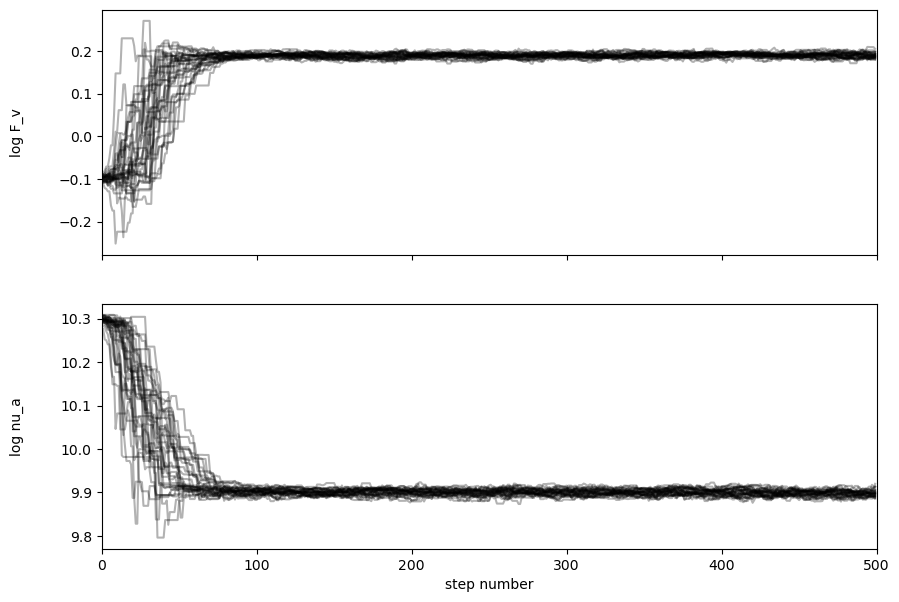

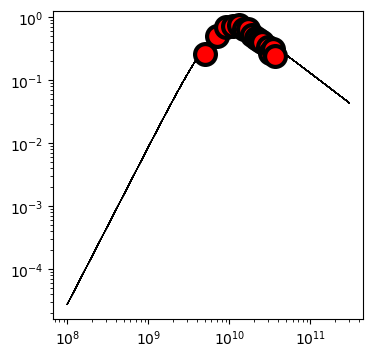

In [15]:
# without mm fit

# try to fit the data
theta_inits = [-0.1,10.3]
n = 500
model = CustomB5
p = 2.97 #syncfit.analysis.get_bounds(sampler, labels=['p', 'log F_v', 'log nu_a', 'log nu_c'], discard=n//2)[0][0]

F_uJy = ds.FluxDensity[ds.Frequency < 8e10/1e9]*1e3
F_err_uJy = ds.FluxDensityErr[ds.Frequency < 8e10/1e9]*1e3

sampler_nomm = syncfit.do_emcee(theta_inits, ds.Frequency[ds.Frequency < 8e10/1e9], F_uJy, F_err_uJy, 
                                plot=True, niter=n, model=model, nwalkers=32, fix_p=p)

out_nomm, log_prob_nomm = syncfit.analysis.extract_output(sampler_nomm)

(1000000000.0, 40000000000.0)

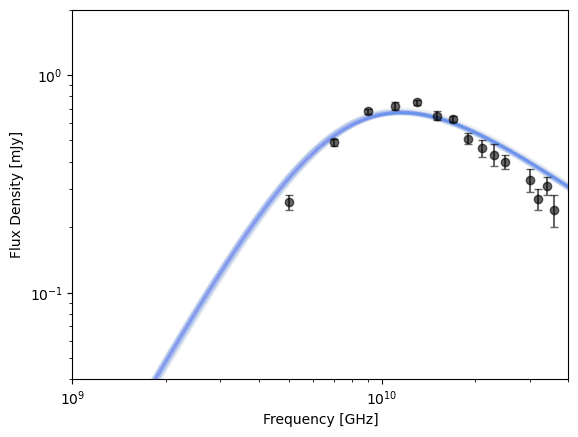

In [16]:
# plot up the data
fig, ax = plt.subplots()
nkeep = 200
nus = np.arange(1e8,3e11,1e7)
best = out_nomm[-nkeep:]#[np.argsort(log_prob_nomm)[-nkeep:]]
nus = np.arange(1e8,3e11,1e7)
for o in best:
    res = CustomB5.SED(nus, p, *o) #
    ax.plot(nus, res, alpha=0.01, linestyle='-', color='cornflowerblue')

F_mJy = ds.FluxDensity[ds.Frequency < 8e10/1e9]
F_err_mJy = ds.FluxDensityErr[ds.Frequency < 8e10/1e9]
ax.errorbar(ds.Frequency[ds.Frequency < 8e10/1e9]*1e9, F_mJy, yerr=F_err_mJy, fmt='o', alpha=0.6, color='k', capsize=3)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('Flux Density [mJy]')
ax.set_xlabel('Frequency [GHz]')

ax.set_ylim(4e-2, 2e0)
ax.set_xlim(1e9, 4e10)

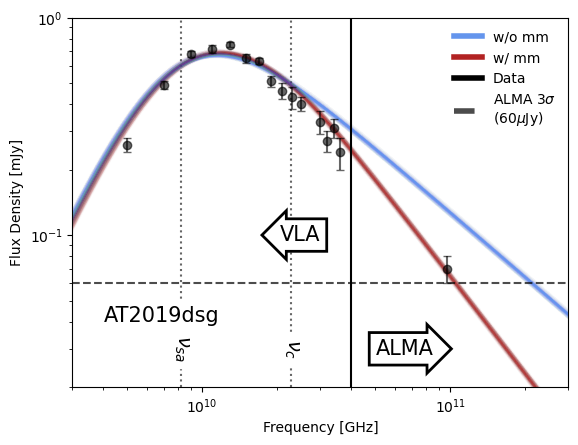

In [17]:
# plot up the data
fig, ax = plt.subplots()
nkeep = 200
nus = np.arange(1e8,3e11,1e7)
best = out[-nkeep:]#[np.argsort(log_prob)[-nkeep:]] #  
for o in best:
    res = CustomB5B3.SED(nus, p, *o)
    ax.plot(nus, res, alpha=0.01, linestyle='-', color='firebrick')

# # plot nu_c vertical line
nu_c = 10**syncfit.analysis.get_bounds(sampler, labels=['p', 'log F_v', 'log nu_a', 'log nu_c'], discard=n//2)[0][-1]
ax.axvline(nu_c, linestyle=':', color='k', alpha=0.6) # pulled from the printout above
ax.text(nu_c, 3e-2, r'$\nu_c$', fontsize=14, ha='center', va='center',
        rotation=-90, alpha=1, backgroundcolor='w')

# # plot nu_c vertical line
nu_a = 10**syncfit.analysis.get_bounds(sampler, labels=['p', 'log F_v', 'log nu_a', 'log nu_c'], discard=n//2)[0][-2]
ax.axvline(nu_a, linestyle=':', color='k', alpha=0.6) # pulled from the printout above
ax.text(nu_a, 3e-2, r'$\nu_{sa}$', fontsize=14, ha='center', va='center',
        rotation=-90, alpha=1, backgroundcolor='w')

best = out_nomm[-nkeep:]#[np.argsort(log_prob_nomm)[-nkeep:]]
nus = np.arange(1e8,3e11,1e7)
for o in best:
    res = CustomB5.SED(nus, p, *o) #
    ax.plot(nus, res, alpha=0.01, linestyle='-', color='cornflowerblue')
    
ax.set_ylim(2e-2, 1e0)
ax.set_xlim(3e9, 3e11)

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

custom_lines = [Line2D([0], [0], color='cornflowerblue', lw=4),
                Line2D([0], [0], color='firebrick', lw=4),
                Line2D([0], [0], color='k', lw=4),
                Line2D([0], [0], color='k', alpha=0.7, linestyle='--', lw=4),
                Patch(facecolor='k', alpha=0.2, hatch='x'),
                Patch(facecolor='k', alpha=0.2, hatch='|')
               ]

labels = ['w/o mm', 'w/ mm', 'Data', 'ALMA 3$\sigma$ \n(60$\mu$Jy)']

ax.errorbar(ds.Frequency*1e9, ds.FluxDensity, yerr=ds.FluxDensityErr, fmt='o', alpha=0.6, color='k', capsize=3)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('Flux Density [mJy]')
ax.set_xlabel('Frequency [Hz]')

# ax.fill_between(VLA_nus*1e9, [1e-50]*len(VLA_nus), [1000]*len(VLA_nus), label='VLA', alpha=0.2, facecolor='w', hatch="x")
# ax.fill_between(ALMA_nus*1e9, [1e-50]*len(ALMA_nus), [1000]*len(ALMA_nus), label='ALMA', alpha=0.2, facecolor="w", hatch="|",)

ax.axvline(40e9, color='k', linestyle='-')
ax.text(30e9, 1e-1, "VLA",
        ha="right", va="center", rotation=0, size=15,
        bbox=dict(boxstyle="larrow,pad=0.3", lw=2, fc='w', ec='k')
       )
ax.text(50e9, 3e-2, "ALMA",
        ha="left", va="center", rotation=0, size=15,
        bbox=dict(boxstyle="rarrow,pad=0.3", lw=2, fc='w', ec='k')
       )

ax.axhline(60e-3, linestyle='--', color='k', alpha=0.7, label='ALMA 3$\sigma$ \n(60$\mu$Jy)')

ax.legend(custom_lines, labels, frameon=False, loc='upper right')

ax.text(4e9, 4e-2, 'AT2019dsg', fontsize=15, backgroundcolor='w')

fig.savefig('2019dsg-sed-plot.png', transparent=False, bbox_inches='tight')

# AT2019qiz

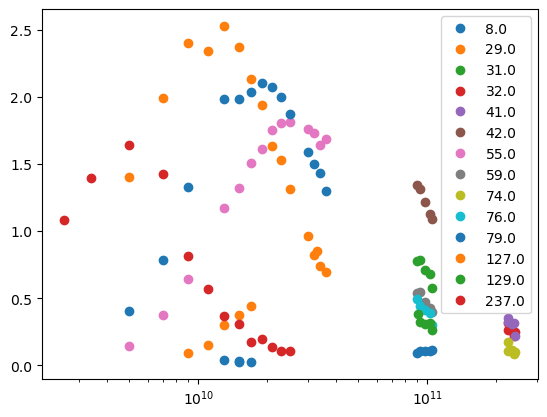

In [5]:
data = pd.DataFrame(np.loadtxt('AT2019qiz_sed.txt'), columns=['t', 'Frequency', 'FluxDensity', 'FluxDensityErr'])
data['FluxDensity'] = data.FluxDensity*1e-3
data['FluxDensityErr'] = data.FluxDensityErr*1e-3


fig, ax = plt.subplots()

# plot the data
for d,grp in data.groupby('t'):
    ax.errorbar(grp.Frequency*1e9, grp.FluxDensity, marker='o', linestyle='none', label=f'{d}')
    
ax.set_xscale('log')
ax.legend()

In [6]:
class CustomB5_qiz(syncfit.models.B5):
    
    def lnprior(theta, p=None, **kwargs):
        ''' Priors: '''
        if p is None:
            p, log_F_nu, log_nu_a = theta
        else:
            log_F_nu, log_nu_a = theta

        if 3 < p < 5 and -4 < log_F_nu < 2 and 6 < log_nu_a < 11:
            return 0.0

        else:
            return -np.inf

  0%|                                                                       | 0/1000 [00:00<?, ?it/s]

  0%|▎                                                              | 4/1000 [00:00<00:25, 39.23it/s]

  1%|▌                                                              | 8/1000 [00:00<00:25, 38.37it/s]

  1%|▋                                                             | 12/1000 [00:00<00:26, 37.89it/s]

  2%|▉                                                             | 16/1000 [00:00<00:25, 38.04it/s]

  2%|█▏                                                            | 20/1000 [00:00<00:25, 38.62it/s]

  2%|█▌                                                            | 25/1000 [00:00<00:24, 40.50it/s]

  3%|█▊                                                            | 30/1000 [00:00<00:22, 42.53it/s]

  4%|██▏                                                           | 35/1000 [00:00<00:21, 44.23it/s]

  4%|██▍                                                           | 40/1000 [00:00<00:21, 45.19it/s]

  4%|██▊                                                           | 45/1000 [00:01<00:20, 46.01it/s]

  5%|███                                                           | 50/1000 [00:01<00:20, 46.62it/s]

  6%|███▍                                                          | 55/1000 [00:01<00:20, 47.07it/s]

  6%|███▋                                                          | 60/1000 [00:01<00:19, 47.71it/s]

  6%|████                                                          | 65/1000 [00:01<00:19, 48.01it/s]

  7%|████▎                                                         | 70/1000 [00:01<00:19, 48.10it/s]

  8%|████▋                                                         | 75/1000 [00:01<00:19, 48.44it/s]

  8%|████▉                                                         | 80/1000 [00:01<00:18, 48.55it/s]

  8%|█████▎                                                        | 85/1000 [00:01<00:18, 48.25it/s]

  9%|█████▌                                                        | 90/1000 [00:01<00:19, 47.30it/s]

 10%|█████▉                                                        | 95/1000 [00:02<00:19, 47.12it/s]

 10%|██████                                                       | 100/1000 [00:02<00:19, 47.22it/s]

 10%|██████▍                                                      | 105/1000 [00:02<00:19, 46.84it/s]

 11%|██████▋                                                      | 110/1000 [00:02<00:19, 46.43it/s]

 12%|███████                                                      | 115/1000 [00:02<00:18, 46.78it/s]

 12%|███████▎                                                     | 120/1000 [00:02<00:19, 44.25it/s]

 12%|███████▋                                                     | 125/1000 [00:02<00:19, 44.72it/s]

 13%|███████▉                                                     | 130/1000 [00:02<00:19, 44.63it/s]

 14%|████████▏                                                    | 135/1000 [00:02<00:19, 44.73it/s]

 14%|████████▌                                                    | 140/1000 [00:03<00:19, 44.84it/s]

 14%|████████▊                                                    | 145/1000 [00:03<00:18, 45.22it/s]

 15%|█████████▏                                                   | 150/1000 [00:03<00:18, 45.26it/s]

 16%|█████████▍                                                   | 155/1000 [00:03<00:18, 44.91it/s]

 16%|█████████▊                                                   | 160/1000 [00:03<00:18, 45.18it/s]

 16%|██████████                                                   | 165/1000 [00:03<00:18, 45.18it/s]

 17%|██████████▎                                                  | 170/1000 [00:03<00:18, 44.96it/s]

 18%|██████████▋                                                  | 175/1000 [00:03<00:18, 44.66it/s]

 18%|██████████▉                                                  | 180/1000 [00:03<00:18, 44.55it/s]

 18%|███████████▎                                                 | 185/1000 [00:04<00:18, 44.54it/s]

 19%|███████████▌                                                 | 190/1000 [00:04<00:18, 44.40it/s]

 20%|███████████▉                                                 | 195/1000 [00:04<00:18, 44.38it/s]

 20%|████████████▏                                                | 200/1000 [00:04<00:18, 44.11it/s]

 20%|████████████▌                                                | 205/1000 [00:04<00:18, 43.78it/s]

 21%|████████████▊                                                | 210/1000 [00:04<00:18, 43.31it/s]

 22%|█████████████                                                | 215/1000 [00:04<00:18, 43.43it/s]

 22%|█████████████▍                                               | 220/1000 [00:04<00:18, 43.27it/s]

 22%|█████████████▋                                               | 225/1000 [00:05<00:18, 42.75it/s]

 23%|██████████████                                               | 230/1000 [00:05<00:17, 43.10it/s]

 24%|██████████████▎                                              | 235/1000 [00:05<00:18, 40.74it/s]

 24%|██████████████▋                                              | 240/1000 [00:05<00:18, 40.74it/s]

 24%|██████████████▉                                              | 245/1000 [00:05<00:18, 40.88it/s]

 25%|███████████████▎                                             | 250/1000 [00:05<00:18, 41.13it/s]

 26%|███████████████▌                                             | 255/1000 [00:05<00:18, 41.17it/s]

 26%|███████████████▊                                             | 260/1000 [00:05<00:18, 41.04it/s]

 26%|████████████████▏                                            | 265/1000 [00:06<00:17, 40.97it/s]

 27%|████████████████▍                                            | 270/1000 [00:06<00:17, 40.73it/s]

 28%|████████████████▊                                            | 275/1000 [00:06<00:17, 40.70it/s]

 28%|█████████████████                                            | 280/1000 [00:06<00:17, 40.92it/s]

 28%|█████████████████▍                                           | 285/1000 [00:06<00:17, 41.03it/s]

 29%|█████████████████▋                                           | 290/1000 [00:06<00:17, 40.97it/s]

 30%|█████████████████▉                                           | 295/1000 [00:06<00:17, 40.93it/s]

 30%|██████████████████▎                                          | 300/1000 [00:06<00:17, 40.91it/s]

 30%|██████████████████▌                                          | 305/1000 [00:06<00:16, 41.21it/s]

 31%|██████████████████▉                                          | 310/1000 [00:07<00:16, 41.09it/s]

 32%|███████████████████▏                                         | 315/1000 [00:07<00:16, 41.08it/s]

 32%|███████████████████▌                                         | 320/1000 [00:07<00:16, 40.92it/s]

 32%|███████████████████▊                                         | 325/1000 [00:07<00:16, 40.57it/s]

 33%|████████████████████▏                                        | 330/1000 [00:07<00:16, 40.47it/s]

 34%|████████████████████▍                                        | 335/1000 [00:07<00:16, 40.67it/s]

 34%|████████████████████▋                                        | 340/1000 [00:07<00:16, 40.50it/s]

 34%|█████████████████████                                        | 345/1000 [00:07<00:16, 40.52it/s]

 35%|█████████████████████▎                                       | 350/1000 [00:08<00:15, 40.72it/s]

 36%|█████████████████████▋                                       | 355/1000 [00:08<00:15, 40.76it/s]

 36%|█████████████████████▉                                       | 360/1000 [00:08<00:15, 40.33it/s]

 36%|██████████████████████▎                                      | 365/1000 [00:08<00:15, 40.42it/s]

 37%|██████████████████████▌                                      | 370/1000 [00:08<00:15, 40.33it/s]

 38%|██████████████████████▉                                      | 375/1000 [00:08<00:15, 40.25it/s]

 38%|███████████████████████▏                                     | 380/1000 [00:08<00:15, 40.15it/s]

 38%|███████████████████████▍                                     | 385/1000 [00:08<00:15, 40.31it/s]

 39%|███████████████████████▊                                     | 390/1000 [00:09<00:15, 40.23it/s]

 40%|████████████████████████                                     | 395/1000 [00:09<00:14, 40.36it/s]

 40%|████████████████████████▍                                    | 400/1000 [00:09<00:14, 40.35it/s]

 40%|████████████████████████▋                                    | 405/1000 [00:09<00:14, 40.40it/s]

 41%|█████████████████████████                                    | 410/1000 [00:09<00:14, 40.23it/s]

 42%|█████████████████████████▎                                   | 415/1000 [00:09<00:14, 40.11it/s]

 42%|█████████████████████████▌                                   | 420/1000 [00:09<00:14, 40.16it/s]

 42%|█████████████████████████▉                                   | 425/1000 [00:09<00:14, 39.94it/s]

 43%|██████████████████████████▏                                  | 430/1000 [00:10<00:14, 40.27it/s]

 44%|██████████████████████████▌                                  | 435/1000 [00:10<00:14, 39.80it/s]

 44%|██████████████████████████▊                                  | 439/1000 [00:10<00:14, 39.78it/s]

 44%|███████████████████████████                                  | 444/1000 [00:10<00:13, 40.38it/s]

 45%|███████████████████████████▍                                 | 449/1000 [00:10<00:13, 40.60it/s]

 45%|███████████████████████████▋                                 | 454/1000 [00:10<00:13, 40.47it/s]

 46%|███████████████████████████▉                                 | 459/1000 [00:10<00:13, 40.24it/s]

 46%|████████████████████████████▎                                | 464/1000 [00:10<00:13, 40.21it/s]

 47%|████████████████████████████▌                                | 469/1000 [00:11<00:13, 40.12it/s]

 47%|████████████████████████████▉                                | 474/1000 [00:11<00:13, 40.00it/s]

 48%|█████████████████████████████▏                               | 479/1000 [00:11<00:13, 39.66it/s]

 48%|█████████████████████████████▍                               | 483/1000 [00:11<00:13, 39.41it/s]

 49%|█████████████████████████████▋                               | 487/1000 [00:11<00:13, 39.13it/s]

 49%|█████████████████████████████▉                               | 491/1000 [00:11<00:13, 38.92it/s]

 50%|██████████████████████████████▏                              | 495/1000 [00:11<00:12, 39.04it/s]

 50%|██████████████████████████████▍                              | 499/1000 [00:11<00:12, 38.94it/s]

 50%|██████████████████████████████▋                              | 503/1000 [00:11<00:12, 38.90it/s]

 51%|██████████████████████████████▉                              | 507/1000 [00:12<00:12, 39.07it/s]

 51%|███████████████████████████████▏                             | 511/1000 [00:12<00:12, 39.07it/s]

 52%|███████████████████████████████▍                             | 516/1000 [00:12<00:12, 39.45it/s]

 52%|███████████████████████████████▋                             | 520/1000 [00:12<00:12, 39.34it/s]

 52%|███████████████████████████████▉                             | 524/1000 [00:12<00:12, 39.38it/s]

 53%|████████████████████████████████▏                            | 528/1000 [00:12<00:11, 39.54it/s]

 53%|████████████████████████████████▍                            | 532/1000 [00:12<00:11, 39.35it/s]

 54%|████████████████████████████████▋                            | 536/1000 [00:12<00:11, 39.18it/s]

 54%|████████████████████████████████▉                            | 540/1000 [00:12<00:11, 39.09it/s]

 54%|█████████████████████████████████▏                           | 544/1000 [00:12<00:11, 38.06it/s]

 55%|█████████████████████████████████▍                           | 548/1000 [00:13<00:12, 37.60it/s]

 55%|█████████████████████████████████▋                           | 552/1000 [00:13<00:11, 37.40it/s]

 56%|█████████████████████████████████▉                           | 556/1000 [00:13<00:11, 37.88it/s]

 56%|██████████████████████████████████▏                          | 560/1000 [00:13<00:11, 38.22it/s]

 56%|██████████████████████████████████▍                          | 564/1000 [00:13<00:11, 37.64it/s]

 57%|██████████████████████████████████▋                          | 568/1000 [00:13<00:11, 38.24it/s]

 57%|██████████████████████████████████▉                          | 572/1000 [00:13<00:11, 38.41it/s]

 58%|███████████████████████████████████▏                         | 576/1000 [00:13<00:11, 38.46it/s]

 58%|███████████████████████████████████▍                         | 580/1000 [00:13<00:10, 38.21it/s]

 58%|███████████████████████████████████▌                         | 584/1000 [00:14<00:10, 38.11it/s]

 59%|███████████████████████████████████▊                         | 588/1000 [00:14<00:10, 37.99it/s]

 59%|████████████████████████████████████                         | 592/1000 [00:14<00:10, 38.13it/s]

 60%|████████████████████████████████████▎                        | 596/1000 [00:14<00:10, 38.20it/s]

 60%|████████████████████████████████████▌                        | 600/1000 [00:14<00:10, 38.24it/s]

 60%|████████████████████████████████████▊                        | 604/1000 [00:14<00:10, 38.42it/s]

 61%|█████████████████████████████████████                        | 608/1000 [00:14<00:10, 38.54it/s]

 61%|█████████████████████████████████████▎                       | 612/1000 [00:14<00:10, 38.19it/s]

 62%|█████████████████████████████████████▌                       | 616/1000 [00:14<00:10, 38.32it/s]

 62%|█████████████████████████████████████▊                       | 620/1000 [00:14<00:09, 38.46it/s]

 62%|██████████████████████████████████████                       | 624/1000 [00:15<00:09, 38.57it/s]

 63%|██████████████████████████████████████▎                      | 628/1000 [00:15<00:09, 38.58it/s]

 63%|██████████████████████████████████████▌                      | 632/1000 [00:15<00:09, 38.87it/s]

 64%|██████████████████████████████████████▊                      | 636/1000 [00:15<00:09, 39.09it/s]

 64%|███████████████████████████████████████                      | 640/1000 [00:15<00:09, 38.71it/s]

 64%|███████████████████████████████████████▎                     | 644/1000 [00:15<00:09, 38.09it/s]

 65%|███████████████████████████████████████▌                     | 648/1000 [00:15<00:09, 38.29it/s]

 65%|███████████████████████████████████████▊                     | 652/1000 [00:15<00:09, 37.67it/s]

 66%|████████████████████████████████████████                     | 656/1000 [00:15<00:09, 36.11it/s]

 66%|████████████████████████████████████████▎                    | 660/1000 [00:16<00:09, 36.24it/s]

 66%|████████████████████████████████████████▌                    | 664/1000 [00:16<00:09, 36.95it/s]

 67%|████████████████████████████████████████▋                    | 668/1000 [00:16<00:08, 37.02it/s]

 67%|████████████████████████████████████████▉                    | 672/1000 [00:16<00:08, 37.15it/s]

 68%|█████████████████████████████████████████▏                   | 676/1000 [00:16<00:08, 37.57it/s]

 68%|█████████████████████████████████████████▍                   | 680/1000 [00:16<00:08, 37.94it/s]

 68%|█████████████████████████████████████████▋                   | 684/1000 [00:16<00:08, 37.88it/s]

 69%|█████████████████████████████████████████▉                   | 688/1000 [00:16<00:08, 37.73it/s]

 69%|██████████████████████████████████████████▏                  | 692/1000 [00:16<00:08, 37.87it/s]

 70%|██████████████████████████████████████████▍                  | 696/1000 [00:16<00:08, 37.59it/s]

 70%|██████████████████████████████████████████▋                  | 700/1000 [00:17<00:07, 37.75it/s]

 70%|██████████████████████████████████████████▉                  | 704/1000 [00:17<00:07, 38.12it/s]

 71%|███████████████████████████████████████████▏                 | 708/1000 [00:17<00:07, 38.06it/s]

 71%|███████████████████████████████████████████▍                 | 712/1000 [00:17<00:07, 37.69it/s]

 72%|███████████████████████████████████████████▋                 | 716/1000 [00:17<00:07, 37.78it/s]

 72%|███████████████████████████████████████████▉                 | 720/1000 [00:17<00:07, 38.41it/s]

 72%|████████████████████████████████████████████▏                | 724/1000 [00:17<00:07, 38.56it/s]

 73%|████████████████████████████████████████████▍                | 728/1000 [00:17<00:07, 38.83it/s]

 73%|████████████████████████████████████████████▋                | 732/1000 [00:17<00:06, 39.01it/s]

 74%|████████████████████████████████████████████▉                | 736/1000 [00:18<00:06, 38.89it/s]

 74%|█████████████████████████████████████████████▏               | 740/1000 [00:18<00:06, 38.69it/s]

 74%|█████████████████████████████████████████████▍               | 744/1000 [00:18<00:06, 38.91it/s]

 75%|█████████████████████████████████████████████▋               | 748/1000 [00:18<00:06, 38.61it/s]

 75%|█████████████████████████████████████████████▊               | 752/1000 [00:18<00:06, 38.11it/s]

 76%|██████████████████████████████████████████████               | 756/1000 [00:18<00:06, 37.90it/s]

 76%|██████████████████████████████████████████████▎              | 760/1000 [00:18<00:06, 37.69it/s]

 76%|██████████████████████████████████████████████▌              | 764/1000 [00:18<00:06, 37.70it/s]

 77%|██████████████████████████████████████████████▊              | 768/1000 [00:18<00:06, 37.55it/s]

 77%|███████████████████████████████████████████████              | 772/1000 [00:18<00:06, 37.04it/s]

 78%|███████████████████████████████████████████████▎             | 776/1000 [00:19<00:06, 37.16it/s]

 78%|███████████████████████████████████████████████▌             | 780/1000 [00:19<00:05, 37.55it/s]

 78%|███████████████████████████████████████████████▊             | 784/1000 [00:19<00:05, 37.94it/s]

 79%|████████████████████████████████████████████████             | 788/1000 [00:19<00:05, 37.73it/s]

 79%|████████████████████████████████████████████████▎            | 792/1000 [00:19<00:05, 37.99it/s]

 80%|████████████████████████████████████████████████▌            | 796/1000 [00:19<00:05, 37.99it/s]

 80%|████████████████████████████████████████████████▊            | 800/1000 [00:19<00:05, 37.40it/s]

 80%|█████████████████████████████████████████████████            | 804/1000 [00:19<00:05, 36.88it/s]

 81%|█████████████████████████████████████████████████▎           | 808/1000 [00:19<00:05, 36.85it/s]

 81%|█████████████████████████████████████████████████▌           | 812/1000 [00:20<00:05, 37.53it/s]

 82%|█████████████████████████████████████████████████▊           | 816/1000 [00:20<00:04, 37.73it/s]

 82%|██████████████████████████████████████████████████           | 820/1000 [00:20<00:04, 37.87it/s]

 82%|██████████████████████████████████████████████████▎          | 824/1000 [00:20<00:04, 38.03it/s]

 83%|██████████████████████████████████████████████████▌          | 828/1000 [00:20<00:04, 37.99it/s]

 83%|██████████████████████████████████████████████████▊          | 832/1000 [00:20<00:04, 38.29it/s]

 84%|██████████████████████████████████████████████████▉          | 836/1000 [00:20<00:04, 38.41it/s]

 84%|███████████████████████████████████████████████████▏         | 840/1000 [00:20<00:04, 38.50it/s]

 84%|███████████████████████████████████████████████████▍         | 844/1000 [00:20<00:04, 37.48it/s]

 85%|███████████████████████████████████████████████████▋         | 848/1000 [00:20<00:04, 37.80it/s]

 85%|███████████████████████████████████████████████████▉         | 852/1000 [00:21<00:03, 38.13it/s]

 86%|████████████████████████████████████████████████████▏        | 856/1000 [00:21<00:03, 38.34it/s]

 86%|████████████████████████████████████████████████████▍        | 860/1000 [00:21<00:03, 37.58it/s]

 86%|████████████████████████████████████████████████████▋        | 864/1000 [00:21<00:03, 38.02it/s]

 87%|████████████████████████████████████████████████████▉        | 868/1000 [00:21<00:03, 38.27it/s]

 87%|█████████████████████████████████████████████████████▏       | 872/1000 [00:21<00:03, 38.02it/s]

 88%|█████████████████████████████████████████████████████▍       | 876/1000 [00:21<00:03, 37.29it/s]

 88%|█████████████████████████████████████████████████████▋       | 880/1000 [00:21<00:03, 37.59it/s]

 88%|█████████████████████████████████████████████████████▉       | 884/1000 [00:21<00:03, 37.55it/s]

 89%|██████████████████████████████████████████████████████▏      | 888/1000 [00:22<00:02, 37.52it/s]

 89%|██████████████████████████████████████████████████████▍      | 892/1000 [00:22<00:02, 37.86it/s]

 90%|██████████████████████████████████████████████████████▋      | 896/1000 [00:22<00:02, 37.91it/s]

 90%|██████████████████████████████████████████████████████▉      | 900/1000 [00:22<00:02, 37.26it/s]

 90%|███████████████████████████████████████████████████████▏     | 904/1000 [00:22<00:02, 37.31it/s]

 91%|███████████████████████████████████████████████████████▍     | 908/1000 [00:22<00:02, 37.94it/s]

 91%|███████████████████████████████████████████████████████▋     | 912/1000 [00:22<00:02, 38.01it/s]

 92%|███████████████████████████████████████████████████████▉     | 916/1000 [00:22<00:02, 37.95it/s]

 92%|████████████████████████████████████████████████████████     | 920/1000 [00:22<00:02, 38.17it/s]

 92%|████████████████████████████████████████████████████████▎    | 924/1000 [00:22<00:01, 38.35it/s]

 93%|████████████████████████████████████████████████████████▌    | 928/1000 [00:23<00:01, 38.42it/s]

 93%|████████████████████████████████████████████████████████▊    | 932/1000 [00:23<00:01, 38.16it/s]

 94%|█████████████████████████████████████████████████████████    | 936/1000 [00:23<00:01, 38.05it/s]

 94%|█████████████████████████████████████████████████████████▎   | 940/1000 [00:23<00:01, 37.83it/s]

 94%|█████████████████████████████████████████████████████████▌   | 944/1000 [00:23<00:01, 38.09it/s]

 95%|█████████████████████████████████████████████████████████▊   | 948/1000 [00:23<00:01, 38.20it/s]

 95%|██████████████████████████████████████████████████████████   | 952/1000 [00:23<00:01, 38.17it/s]

 96%|██████████████████████████████████████████████████████████▎  | 956/1000 [00:23<00:01, 37.92it/s]

 96%|██████████████████████████████████████████████████████████▌  | 960/1000 [00:23<00:01, 37.31it/s]

 96%|██████████████████████████████████████████████████████████▊  | 964/1000 [00:24<00:00, 36.54it/s]

 97%|███████████████████████████████████████████████████████████  | 968/1000 [00:24<00:00, 37.01it/s]

 97%|███████████████████████████████████████████████████████████▎ | 972/1000 [00:24<00:00, 37.13it/s]

 98%|███████████████████████████████████████████████████████████▌ | 976/1000 [00:24<00:00, 37.42it/s]

 98%|███████████████████████████████████████████████████████████▊ | 980/1000 [00:24<00:00, 37.51it/s]

 98%|████████████████████████████████████████████████████████████ | 984/1000 [00:24<00:00, 37.55it/s]

 99%|████████████████████████████████████████████████████████████▎| 988/1000 [00:24<00:00, 37.57it/s]

 99%|████████████████████████████████████████████████████████████▌| 992/1000 [00:24<00:00, 37.75it/s]

100%|████████████████████████████████████████████████████████████▊| 996/1000 [00:24<00:00, 37.73it/s]

100%|████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 37.64it/s]

100%|████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 39.97it/s]

  0%|                                                                       | 0/1000 [00:00<?, ?it/s]

  0%|▎                                                              | 4/1000 [00:00<00:26, 37.01it/s]

  1%|▌                                                              | 8/1000 [00:00<00:26, 36.91it/s]

  1%|▋                                                             | 12/1000 [00:00<00:26, 36.80it/s]

  2%|▉                                                             | 16/1000 [00:00<00:26, 36.73it/s]

  2%|█▏                                                            | 20/1000 [00:00<00:26, 37.11it/s]

  2%|█▍                                                            | 24/1000 [00:00<00:26, 37.25it/s]

  3%|█▋                                                            | 28/1000 [00:00<00:25, 37.50it/s]

  3%|█▉                                                            | 32/1000 [00:00<00:25, 37.38it/s]

  4%|██▏                                                           | 36/1000 [00:00<00:25, 37.74it/s]

  4%|██▍                                                           | 40/1000 [00:01<00:25, 38.18it/s]

  4%|██▊                                                           | 45/1000 [00:01<00:24, 38.94it/s]

  5%|███                                                           | 50/1000 [00:01<00:24, 39.48it/s]

  5%|███▎                                                          | 54/1000 [00:01<00:24, 39.41it/s]

  6%|███▌                                                          | 58/1000 [00:01<00:23, 39.41it/s]

  6%|███▉                                                          | 63/1000 [00:01<00:23, 39.90it/s]

  7%|████▏                                                         | 68/1000 [00:01<00:23, 40.21it/s]

  7%|████▌                                                         | 73/1000 [00:01<00:23, 39.69it/s]

  8%|████▊                                                         | 77/1000 [00:01<00:23, 38.92it/s]

  8%|█████                                                         | 81/1000 [00:02<00:23, 38.66it/s]

  9%|█████▎                                                        | 86/1000 [00:02<00:23, 39.06it/s]

  9%|█████▌                                                        | 90/1000 [00:02<00:23, 39.00it/s]

 10%|█████▉                                                        | 95/1000 [00:02<00:22, 39.48it/s]

 10%|██████▏                                                       | 99/1000 [00:02<00:23, 39.06it/s]

 10%|██████▎                                                      | 103/1000 [00:02<00:23, 38.64it/s]

 11%|██████▌                                                      | 107/1000 [00:02<00:23, 38.72it/s]

 11%|██████▊                                                      | 111/1000 [00:02<00:23, 38.46it/s]

 12%|███████                                                      | 115/1000 [00:02<00:23, 38.30it/s]

 12%|███████▎                                                     | 119/1000 [00:03<00:22, 38.53it/s]

 12%|███████▌                                                     | 123/1000 [00:03<00:22, 38.50it/s]

 13%|███████▋                                                     | 127/1000 [00:03<00:23, 37.86it/s]

 13%|███████▉                                                     | 131/1000 [00:03<00:23, 37.28it/s]

 14%|████████▏                                                    | 135/1000 [00:03<00:22, 37.87it/s]

 14%|████████▍                                                    | 139/1000 [00:03<00:22, 38.07it/s]

 14%|████████▋                                                    | 143/1000 [00:03<00:22, 38.21it/s]

 15%|████████▉                                                    | 147/1000 [00:03<00:22, 38.10it/s]

 15%|█████████▏                                                   | 151/1000 [00:03<00:22, 37.63it/s]

 16%|█████████▍                                                   | 155/1000 [00:04<00:22, 37.65it/s]

 16%|█████████▋                                                   | 159/1000 [00:04<00:22, 37.71it/s]

 16%|█████████▉                                                   | 163/1000 [00:04<00:22, 38.02it/s]

 17%|██████████▏                                                  | 167/1000 [00:04<00:22, 37.72it/s]

 17%|██████████▍                                                  | 171/1000 [00:04<00:21, 37.80it/s]

 18%|██████████▋                                                  | 175/1000 [00:04<00:21, 37.80it/s]

 18%|██████████▉                                                  | 179/1000 [00:04<00:21, 37.84it/s]

 18%|███████████▏                                                 | 183/1000 [00:04<00:21, 37.82it/s]

 19%|███████████▍                                                 | 187/1000 [00:04<00:21, 37.84it/s]

 19%|███████████▋                                                 | 191/1000 [00:04<00:21, 37.97it/s]

 20%|███████████▉                                                 | 195/1000 [00:05<00:21, 37.86it/s]

 20%|████████████▏                                                | 199/1000 [00:05<00:21, 37.19it/s]

 20%|████████████▍                                                | 203/1000 [00:05<00:21, 36.90it/s]

 21%|████████████▋                                                | 207/1000 [00:05<00:21, 36.89it/s]

 21%|████████████▊                                                | 211/1000 [00:05<00:21, 36.62it/s]

 22%|█████████████                                                | 215/1000 [00:05<00:22, 35.63it/s]

 22%|█████████████▎                                               | 219/1000 [00:05<00:21, 35.66it/s]

 22%|█████████████▌                                               | 223/1000 [00:05<00:21, 35.98it/s]

 23%|█████████████▊                                               | 227/1000 [00:05<00:21, 35.98it/s]

 23%|██████████████                                               | 231/1000 [00:06<00:21, 36.40it/s]

 24%|██████████████▎                                              | 235/1000 [00:06<00:20, 36.61it/s]

 24%|██████████████▌                                              | 239/1000 [00:06<00:20, 36.82it/s]

 24%|██████████████▊                                              | 243/1000 [00:06<00:20, 36.94it/s]

 25%|███████████████                                              | 247/1000 [00:06<00:20, 37.05it/s]

 25%|███████████████▎                                             | 251/1000 [00:06<00:20, 37.13it/s]

 26%|███████████████▌                                             | 255/1000 [00:06<00:19, 37.27it/s]

 26%|███████████████▊                                             | 259/1000 [00:06<00:19, 37.30it/s]

 26%|████████████████                                             | 263/1000 [00:06<00:20, 36.78it/s]

 27%|████████████████▎                                            | 267/1000 [00:07<00:19, 36.84it/s]

 27%|████████████████▌                                            | 271/1000 [00:07<00:19, 36.56it/s]

 28%|████████████████▊                                            | 275/1000 [00:07<00:19, 36.76it/s]

 28%|█████████████████                                            | 279/1000 [00:07<00:19, 37.19it/s]

 28%|█████████████████▎                                           | 283/1000 [00:07<00:19, 37.18it/s]

 29%|█████████████████▌                                           | 287/1000 [00:07<00:19, 37.29it/s]

 29%|█████████████████▊                                           | 291/1000 [00:07<00:18, 37.32it/s]

 30%|█████████████████▉                                           | 295/1000 [00:07<00:18, 37.24it/s]

 30%|██████████████████▏                                          | 299/1000 [00:07<00:18, 37.36it/s]

 30%|██████████████████▍                                          | 303/1000 [00:08<00:18, 37.58it/s]

 31%|██████████████████▋                                          | 307/1000 [00:08<00:19, 36.26it/s]

 31%|██████████████████▉                                          | 311/1000 [00:08<00:18, 36.36it/s]

 32%|███████████████████▏                                         | 315/1000 [00:08<00:18, 36.26it/s]

 32%|███████████████████▍                                         | 319/1000 [00:08<00:18, 35.86it/s]

 32%|███████████████████▋                                         | 323/1000 [00:08<00:19, 35.61it/s]

 33%|███████████████████▉                                         | 327/1000 [00:08<00:18, 36.29it/s]

 33%|████████████████████▏                                        | 331/1000 [00:08<00:18, 36.65it/s]

 34%|████████████████████▍                                        | 335/1000 [00:08<00:18, 36.63it/s]

 34%|████████████████████▋                                        | 339/1000 [00:09<00:17, 37.02it/s]

 34%|████████████████████▉                                        | 343/1000 [00:09<00:17, 37.43it/s]

 35%|█████████████████████▏                                       | 347/1000 [00:09<00:17, 37.67it/s]

 35%|█████████████████████▍                                       | 351/1000 [00:09<00:17, 37.79it/s]

 36%|█████████████████████▋                                       | 355/1000 [00:09<00:17, 37.78it/s]

 36%|█████████████████████▉                                       | 359/1000 [00:09<00:16, 37.77it/s]

 36%|██████████████████████▏                                      | 363/1000 [00:09<00:16, 37.74it/s]

 37%|██████████████████████▍                                      | 367/1000 [00:09<00:16, 37.84it/s]

 37%|██████████████████████▋                                      | 371/1000 [00:09<00:16, 37.29it/s]

 38%|██████████████████████▉                                      | 375/1000 [00:09<00:16, 37.60it/s]

 38%|███████████████████████                                      | 379/1000 [00:10<00:16, 37.75it/s]

 38%|███████████████████████▎                                     | 383/1000 [00:10<00:16, 37.68it/s]

 39%|███████████████████████▌                                     | 387/1000 [00:10<00:16, 36.83it/s]

 39%|███████████████████████▊                                     | 391/1000 [00:10<00:16, 37.37it/s]

 40%|████████████████████████                                     | 395/1000 [00:10<00:16, 37.53it/s]

 40%|████████████████████████▎                                    | 399/1000 [00:10<00:15, 37.58it/s]

 40%|████████████████████████▌                                    | 403/1000 [00:10<00:15, 37.62it/s]

 41%|████████████████████████▊                                    | 407/1000 [00:10<00:15, 37.52it/s]

 41%|█████████████████████████                                    | 411/1000 [00:10<00:15, 37.44it/s]

 42%|█████████████████████████▎                                   | 415/1000 [00:11<00:15, 37.17it/s]

 42%|█████████████████████████▌                                   | 419/1000 [00:11<00:15, 37.17it/s]

 42%|█████████████████████████▊                                   | 423/1000 [00:11<00:15, 37.47it/s]

 43%|██████████████████████████                                   | 427/1000 [00:11<00:15, 37.44it/s]

 43%|██████████████████████████▎                                  | 431/1000 [00:11<00:15, 36.96it/s]

 44%|██████████████████████████▌                                  | 435/1000 [00:11<00:15, 37.00it/s]

 44%|██████████████████████████▊                                  | 439/1000 [00:11<00:15, 37.01it/s]

 44%|███████████████████████████                                  | 443/1000 [00:11<00:14, 37.17it/s]

 45%|███████████████████████████▎                                 | 447/1000 [00:11<00:14, 37.15it/s]

 45%|███████████████████████████▌                                 | 451/1000 [00:12<00:14, 37.22it/s]

 46%|███████████████████████████▊                                 | 455/1000 [00:12<00:14, 37.32it/s]

 46%|███████████████████████████▉                                 | 459/1000 [00:12<00:14, 37.33it/s]

 46%|████████████████████████████▏                                | 463/1000 [00:12<00:14, 37.23it/s]

 47%|████████████████████████████▍                                | 467/1000 [00:12<00:14, 37.43it/s]

 47%|████████████████████████████▋                                | 471/1000 [00:12<00:14, 37.59it/s]

 48%|████████████████████████████▉                                | 475/1000 [00:12<00:14, 37.20it/s]

 48%|█████████████████████████████▏                               | 479/1000 [00:12<00:14, 37.03it/s]

 48%|█████████████████████████████▍                               | 483/1000 [00:12<00:13, 37.02it/s]

 49%|█████████████████████████████▋                               | 487/1000 [00:12<00:13, 37.22it/s]

 49%|█████████████████████████████▉                               | 491/1000 [00:13<00:13, 37.30it/s]

 50%|██████████████████████████████▏                              | 495/1000 [00:13<00:13, 37.24it/s]

 50%|██████████████████████████████▍                              | 499/1000 [00:13<00:13, 37.73it/s]

 50%|██████████████████████████████▋                              | 503/1000 [00:13<00:13, 37.67it/s]

 51%|██████████████████████████████▉                              | 507/1000 [00:13<00:13, 37.56it/s]

 51%|███████████████████████████████▏                             | 511/1000 [00:13<00:12, 37.62it/s]

 52%|███████████████████████████████▍                             | 515/1000 [00:13<00:12, 37.48it/s]

 52%|███████████████████████████████▋                             | 519/1000 [00:13<00:12, 37.33it/s]

 52%|███████████████████████████████▉                             | 523/1000 [00:13<00:12, 37.36it/s]

 53%|████████████████████████████████▏                            | 527/1000 [00:14<00:12, 37.55it/s]

 53%|████████████████████████████████▍                            | 531/1000 [00:14<00:12, 37.38it/s]

 54%|████████████████████████████████▋                            | 535/1000 [00:14<00:12, 37.19it/s]

 54%|████████████████████████████████▉                            | 539/1000 [00:14<00:12, 36.65it/s]

 54%|█████████████████████████████████                            | 543/1000 [00:14<00:12, 36.03it/s]

 55%|█████████████████████████████████▎                           | 547/1000 [00:14<00:12, 36.30it/s]

 55%|█████████████████████████████████▌                           | 551/1000 [00:14<00:12, 36.45it/s]

 56%|█████████████████████████████████▊                           | 555/1000 [00:14<00:12, 36.52it/s]

 56%|██████████████████████████████████                           | 559/1000 [00:14<00:12, 36.36it/s]

 56%|██████████████████████████████████▎                          | 563/1000 [00:15<00:12, 36.17it/s]

 57%|██████████████████████████████████▌                          | 567/1000 [00:15<00:12, 34.87it/s]

 57%|██████████████████████████████████▊                          | 571/1000 [00:15<00:12, 35.53it/s]

 57%|███████████████████████████████████                          | 575/1000 [00:15<00:11, 35.47it/s]

 58%|███████████████████████████████████▎                         | 579/1000 [00:15<00:11, 35.79it/s]

 58%|███████████████████████████████████▌                         | 583/1000 [00:15<00:11, 35.90it/s]

 59%|███████████████████████████████████▊                         | 587/1000 [00:15<00:11, 35.83it/s]

 59%|████████████████████████████████████                         | 591/1000 [00:15<00:11, 36.29it/s]

 60%|████████████████████████████████████▎                        | 595/1000 [00:15<00:10, 36.86it/s]

 60%|████████████████████████████████████▌                        | 599/1000 [00:16<00:10, 36.96it/s]

 60%|████████████████████████████████████▊                        | 603/1000 [00:16<00:10, 37.19it/s]

 61%|█████████████████████████████████████                        | 607/1000 [00:16<00:10, 37.13it/s]

 61%|█████████████████████████████████████▎                       | 611/1000 [00:16<00:10, 37.04it/s]

 62%|█████████████████████████████████████▌                       | 615/1000 [00:16<00:10, 36.75it/s]

 62%|█████████████████████████████████████▊                       | 619/1000 [00:16<00:10, 36.50it/s]

 62%|██████████████████████████████████████                       | 623/1000 [00:16<00:10, 36.26it/s]

 63%|██████████████████████████████████████▏                      | 627/1000 [00:16<00:10, 36.44it/s]

 63%|██████████████████████████████████████▍                      | 631/1000 [00:16<00:10, 36.69it/s]

 64%|██████████████████████████████████████▋                      | 635/1000 [00:17<00:09, 36.71it/s]

 64%|██████████████████████████████████████▉                      | 639/1000 [00:17<00:09, 36.78it/s]

 64%|███████████████████████████████████████▏                     | 643/1000 [00:17<00:09, 36.78it/s]

 65%|███████████████████████████████████████▍                     | 647/1000 [00:17<00:09, 37.00it/s]

 65%|███████████████████████████████████████▋                     | 651/1000 [00:17<00:09, 36.96it/s]

 66%|███████████████████████████████████████▉                     | 655/1000 [00:17<00:09, 36.90it/s]

 66%|████████████████████████████████████████▏                    | 659/1000 [00:17<00:09, 36.47it/s]

 66%|████████████████████████████████████████▍                    | 663/1000 [00:17<00:09, 36.26it/s]

 67%|████████████████████████████████████████▋                    | 667/1000 [00:17<00:09, 36.53it/s]

 67%|████████████████████████████████████████▉                    | 671/1000 [00:18<00:09, 35.73it/s]

 68%|█████████████████████████████████████████▏                   | 675/1000 [00:18<00:09, 35.85it/s]

 68%|█████████████████████████████████████████▍                   | 679/1000 [00:18<00:08, 36.14it/s]

 68%|█████████████████████████████████████████▋                   | 683/1000 [00:18<00:08, 36.51it/s]

 69%|█████████████████████████████████████████▉                   | 687/1000 [00:18<00:08, 36.89it/s]

 69%|██████████████████████████████████████████▏                  | 691/1000 [00:18<00:08, 37.37it/s]

 70%|██████████████████████████████████████████▍                  | 695/1000 [00:18<00:08, 37.35it/s]

 70%|██████████████████████████████████████████▋                  | 699/1000 [00:18<00:08, 37.29it/s]

 70%|██████████████████████████████████████████▉                  | 703/1000 [00:18<00:07, 37.27it/s]

 71%|███████████████████████████████████████████▏                 | 707/1000 [00:18<00:07, 37.38it/s]

 71%|███████████████████████████████████████████▎                 | 711/1000 [00:19<00:07, 37.30it/s]

 72%|███████████████████████████████████████████▌                 | 715/1000 [00:19<00:07, 37.55it/s]

 72%|███████████████████████████████████████████▊                 | 719/1000 [00:19<00:07, 37.73it/s]

 72%|████████████████████████████████████████████                 | 723/1000 [00:19<00:07, 37.59it/s]

 73%|████████████████████████████████████████████▎                | 727/1000 [00:19<00:07, 37.62it/s]

 73%|████████████████████████████████████████████▌                | 731/1000 [00:19<00:07, 37.75it/s]

 74%|████████████████████████████████████████████▊                | 735/1000 [00:19<00:07, 37.17it/s]

 74%|█████████████████████████████████████████████                | 739/1000 [00:19<00:07, 37.22it/s]

 74%|█████████████████████████████████████████████▎               | 743/1000 [00:19<00:06, 37.25it/s]

 75%|█████████████████████████████████████████████▌               | 747/1000 [00:20<00:06, 36.89it/s]

 75%|█████████████████████████████████████████████▊               | 751/1000 [00:20<00:06, 36.47it/s]

 76%|██████████████████████████████████████████████               | 755/1000 [00:20<00:06, 36.43it/s]

 76%|██████████████████████████████████████████████▎              | 759/1000 [00:20<00:06, 36.43it/s]

 76%|██████████████████████████████████████████████▌              | 763/1000 [00:20<00:06, 36.49it/s]

 77%|██████████████████████████████████████████████▊              | 767/1000 [00:20<00:06, 36.42it/s]

 77%|███████████████████████████████████████████████              | 771/1000 [00:20<00:06, 36.83it/s]

 78%|███████████████████████████████████████████████▎             | 775/1000 [00:20<00:06, 37.04it/s]

 78%|███████████████████████████████████████████████▌             | 779/1000 [00:20<00:05, 36.92it/s]

 78%|███████████████████████████████████████████████▊             | 783/1000 [00:21<00:05, 37.04it/s]

 79%|████████████████████████████████████████████████             | 787/1000 [00:21<00:05, 37.28it/s]

 79%|████████████████████████████████████████████████▎            | 791/1000 [00:21<00:05, 37.43it/s]

 80%|████████████████████████████████████████████████▍            | 795/1000 [00:21<00:05, 37.45it/s]

 80%|████████████████████████████████████████████████▋            | 799/1000 [00:21<00:05, 37.39it/s]

 80%|████████████████████████████████████████████████▉            | 803/1000 [00:21<00:05, 37.55it/s]

 81%|█████████████████████████████████████████████████▏           | 807/1000 [00:21<00:05, 37.58it/s]

 81%|█████████████████████████████████████████████████▍           | 811/1000 [00:21<00:05, 37.53it/s]

 82%|█████████████████████████████████████████████████▋           | 815/1000 [00:21<00:04, 37.41it/s]

 82%|█████████████████████████████████████████████████▉           | 819/1000 [00:21<00:04, 37.51it/s]

 82%|██████████████████████████████████████████████████▏          | 823/1000 [00:22<00:04, 37.57it/s]

 83%|██████████████████████████████████████████████████▍          | 827/1000 [00:22<00:04, 37.60it/s]

 83%|██████████████████████████████████████████████████▋          | 831/1000 [00:22<00:04, 37.60it/s]

 84%|██████████████████████████████████████████████████▉          | 835/1000 [00:22<00:04, 37.65it/s]

 84%|███████████████████████████████████████████████████▏         | 839/1000 [00:22<00:04, 37.65it/s]

 84%|███████████████████████████████████████████████████▍         | 843/1000 [00:22<00:04, 37.66it/s]

 85%|███████████████████████████████████████████████████▋         | 847/1000 [00:22<00:04, 37.67it/s]

 85%|███████████████████████████████████████████████████▉         | 851/1000 [00:22<00:03, 37.76it/s]

 86%|████████████████████████████████████████████████████▏        | 855/1000 [00:22<00:03, 37.77it/s]

 86%|████████████████████████████████████████████████████▍        | 859/1000 [00:23<00:03, 37.57it/s]

 86%|████████████████████████████████████████████████████▋        | 863/1000 [00:23<00:03, 37.38it/s]

 87%|████████████████████████████████████████████████████▉        | 867/1000 [00:23<00:03, 37.28it/s]

 87%|█████████████████████████████████████████████████████▏       | 871/1000 [00:23<00:03, 37.35it/s]

 88%|█████████████████████████████████████████████████████▍       | 875/1000 [00:23<00:03, 37.42it/s]

 88%|█████████████████████████████████████████████████████▌       | 879/1000 [00:23<00:03, 37.06it/s]

 88%|█████████████████████████████████████████████████████▊       | 883/1000 [00:23<00:03, 36.55it/s]

 89%|██████████████████████████████████████████████████████       | 887/1000 [00:23<00:03, 36.65it/s]

 89%|██████████████████████████████████████████████████████▎      | 891/1000 [00:23<00:02, 36.87it/s]

 90%|██████████████████████████████████████████████████████▌      | 895/1000 [00:24<00:02, 36.98it/s]

 90%|██████████████████████████████████████████████████████▊      | 899/1000 [00:24<00:02, 37.13it/s]

 90%|███████████████████████████████████████████████████████      | 903/1000 [00:24<00:02, 36.88it/s]

 91%|███████████████████████████████████████████████████████▎     | 907/1000 [00:24<00:02, 36.88it/s]

 91%|███████████████████████████████████████████████████████▌     | 911/1000 [00:24<00:02, 36.90it/s]

 92%|███████████████████████████████████████████████████████▊     | 915/1000 [00:24<00:02, 36.76it/s]

 92%|████████████████████████████████████████████████████████     | 919/1000 [00:24<00:02, 36.70it/s]

 92%|████████████████████████████████████████████████████████▎    | 923/1000 [00:24<00:02, 37.04it/s]

 93%|████████████████████████████████████████████████████████▌    | 927/1000 [00:24<00:01, 37.31it/s]

 93%|████████████████████████████████████████████████████████▊    | 931/1000 [00:24<00:01, 37.34it/s]

 94%|█████████████████████████████████████████████████████████    | 935/1000 [00:25<00:01, 37.46it/s]

 94%|█████████████████████████████████████████████████████████▎   | 939/1000 [00:25<00:01, 37.38it/s]

 94%|█████████████████████████████████████████████████████████▌   | 943/1000 [00:25<00:01, 37.09it/s]

 95%|█████████████████████████████████████████████████████████▊   | 947/1000 [00:25<00:01, 37.17it/s]

 95%|██████████████████████████████████████████████████████████   | 951/1000 [00:25<00:01, 37.43it/s]

 96%|██████████████████████████████████████████████████████████▎  | 955/1000 [00:25<00:01, 36.91it/s]

 96%|██████████████████████████████████████████████████████████▍  | 959/1000 [00:25<00:01, 36.83it/s]

 96%|██████████████████████████████████████████████████████████▋  | 963/1000 [00:25<00:01, 36.89it/s]

 97%|██████████████████████████████████████████████████████████▉  | 967/1000 [00:25<00:00, 37.20it/s]

 97%|███████████████████████████████████████████████████████████▏ | 971/1000 [00:26<00:00, 37.30it/s]

 98%|███████████████████████████████████████████████████████████▍ | 975/1000 [00:26<00:00, 37.11it/s]

 98%|███████████████████████████████████████████████████████████▋ | 979/1000 [00:26<00:00, 36.76it/s]

 98%|███████████████████████████████████████████████████████████▉ | 983/1000 [00:26<00:00, 36.61it/s]

 99%|████████████████████████████████████████████████████████████▏| 987/1000 [00:26<00:00, 37.04it/s]

 99%|████████████████████████████████████████████████████████████▍| 991/1000 [00:26<00:00, 37.12it/s]

100%|████████████████████████████████████████████████████████████▋| 995/1000 [00:26<00:00, 37.11it/s]

100%|████████████████████████████████████████████████████████████▉| 999/1000 [00:26<00:00, 37.01it/s]

100%|████████████████████████████████████████████████████████████| 1000/1000 [00:26<00:00, 37.23it/s]

  0%|                                                                       | 0/1000 [00:00<?, ?it/s]

  0%|▎                                                              | 4/1000 [00:00<00:27, 36.69it/s]

  1%|▌                                                              | 8/1000 [00:00<00:27, 36.64it/s]

  1%|▋                                                             | 12/1000 [00:00<00:27, 36.54it/s]

  2%|▉                                                             | 16/1000 [00:00<00:27, 36.42it/s]

  2%|█▏                                                            | 20/1000 [00:00<00:26, 37.10it/s]

  2%|█▍                                                            | 24/1000 [00:00<00:25, 37.56it/s]

  3%|█▋                                                            | 28/1000 [00:00<00:26, 37.35it/s]

  3%|█▉                                                            | 32/1000 [00:00<00:26, 37.19it/s]

  4%|██▏                                                           | 36/1000 [00:00<00:26, 36.99it/s]

  4%|██▍                                                           | 40/1000 [00:01<00:26, 36.57it/s]

  4%|██▋                                                           | 44/1000 [00:01<00:25, 37.20it/s]

  5%|██▉                                                           | 48/1000 [00:01<00:25, 37.25it/s]

  5%|███▏                                                          | 52/1000 [00:01<00:25, 37.29it/s]

  6%|███▍                                                          | 56/1000 [00:01<00:25, 37.31it/s]

  6%|███▋                                                          | 60/1000 [00:01<00:25, 37.27it/s]

  6%|███▉                                                          | 64/1000 [00:01<00:25, 37.41it/s]

  7%|████▏                                                         | 68/1000 [00:01<00:24, 37.38it/s]

  7%|████▍                                                         | 72/1000 [00:01<00:24, 37.28it/s]

  8%|████▋                                                         | 76/1000 [00:02<00:24, 37.31it/s]

  8%|████▉                                                         | 80/1000 [00:02<00:24, 37.32it/s]

  8%|█████▏                                                        | 84/1000 [00:02<00:24, 37.18it/s]

  9%|█████▍                                                        | 88/1000 [00:02<00:24, 37.25it/s]

  9%|█████▋                                                        | 92/1000 [00:02<00:24, 37.30it/s]

 10%|█████▉                                                        | 96/1000 [00:02<00:24, 37.14it/s]

 10%|██████                                                       | 100/1000 [00:02<00:24, 37.06it/s]

 10%|██████▎                                                      | 104/1000 [00:02<00:24, 37.13it/s]

 11%|██████▌                                                      | 108/1000 [00:02<00:23, 37.19it/s]

 11%|██████▊                                                      | 112/1000 [00:03<00:23, 37.07it/s]

 12%|███████                                                      | 116/1000 [00:03<00:23, 37.10it/s]

 12%|███████▎                                                     | 120/1000 [00:03<00:23, 37.26it/s]

 12%|███████▌                                                     | 124/1000 [00:03<00:23, 37.24it/s]

 13%|███████▊                                                     | 128/1000 [00:03<00:23, 37.35it/s]

 13%|████████                                                     | 132/1000 [00:03<00:23, 37.26it/s]

 14%|████████▎                                                    | 136/1000 [00:03<00:23, 37.07it/s]

 14%|████████▌                                                    | 140/1000 [00:03<00:22, 37.46it/s]

 14%|████████▊                                                    | 144/1000 [00:03<00:22, 37.37it/s]

 15%|█████████                                                    | 148/1000 [00:03<00:22, 37.05it/s]

 15%|█████████▎                                                   | 152/1000 [00:04<00:23, 36.59it/s]

 16%|█████████▌                                                   | 156/1000 [00:04<00:22, 36.74it/s]

 16%|█████████▊                                                   | 160/1000 [00:04<00:22, 36.75it/s]

 16%|██████████                                                   | 164/1000 [00:04<00:22, 37.04it/s]

 17%|██████████▏                                                  | 168/1000 [00:04<00:22, 37.10it/s]

 17%|██████████▍                                                  | 172/1000 [00:04<00:22, 37.15it/s]

 18%|██████████▋                                                  | 176/1000 [00:04<00:22, 37.09it/s]

 18%|██████████▉                                                  | 180/1000 [00:04<00:22, 37.11it/s]

 18%|███████████▏                                                 | 184/1000 [00:04<00:22, 37.01it/s]

 19%|███████████▍                                                 | 188/1000 [00:05<00:22, 36.88it/s]

 19%|███████████▋                                                 | 192/1000 [00:05<00:21, 37.00it/s]

 20%|███████████▉                                                 | 196/1000 [00:05<00:21, 36.91it/s]

 20%|████████████▏                                                | 200/1000 [00:05<00:21, 36.53it/s]

 20%|████████████▍                                                | 204/1000 [00:05<00:21, 36.43it/s]

 21%|████████████▋                                                | 208/1000 [00:05<00:21, 36.43it/s]

 21%|████████████▉                                                | 212/1000 [00:05<00:21, 35.99it/s]

 22%|█████████████▏                                               | 216/1000 [00:05<00:21, 36.22it/s]

 22%|█████████████▍                                               | 220/1000 [00:05<00:21, 36.31it/s]

 22%|█████████████▋                                               | 224/1000 [00:06<00:21, 36.46it/s]

 23%|█████████████▉                                               | 228/1000 [00:06<00:21, 36.57it/s]

 23%|██████████████▏                                              | 232/1000 [00:06<00:20, 36.61it/s]

 24%|██████████████▍                                              | 236/1000 [00:06<00:20, 36.50it/s]

 24%|██████████████▋                                              | 240/1000 [00:06<00:20, 36.64it/s]

 24%|██████████████▉                                              | 244/1000 [00:06<00:20, 36.92it/s]

 25%|███████████████▏                                             | 248/1000 [00:06<00:20, 37.02it/s]

 25%|███████████████▎                                             | 252/1000 [00:06<00:20, 37.22it/s]

 26%|███████████████▌                                             | 256/1000 [00:06<00:20, 37.04it/s]

 26%|███████████████▊                                             | 260/1000 [00:07<00:20, 36.97it/s]

 26%|████████████████                                             | 264/1000 [00:07<00:19, 37.03it/s]

 27%|████████████████▎                                            | 268/1000 [00:07<00:19, 37.11it/s]

 27%|████████████████▌                                            | 272/1000 [00:07<00:19, 37.11it/s]

 28%|████████████████▊                                            | 276/1000 [00:07<00:19, 36.97it/s]

 28%|█████████████████                                            | 280/1000 [00:07<00:19, 37.02it/s]

 28%|█████████████████▎                                           | 284/1000 [00:07<00:19, 37.12it/s]

 29%|█████████████████▌                                           | 288/1000 [00:07<00:19, 37.12it/s]

 29%|█████████████████▊                                           | 292/1000 [00:07<00:19, 37.14it/s]

 30%|██████████████████                                           | 296/1000 [00:07<00:18, 37.13it/s]

 30%|██████████████████▎                                          | 300/1000 [00:08<00:18, 37.21it/s]

 30%|██████████████████▌                                          | 304/1000 [00:08<00:18, 37.32it/s]

 31%|██████████████████▊                                          | 308/1000 [00:08<00:18, 37.33it/s]

 31%|███████████████████                                          | 312/1000 [00:08<00:18, 37.40it/s]

 32%|███████████████████▎                                         | 316/1000 [00:08<00:18, 37.34it/s]

 32%|███████████████████▌                                         | 320/1000 [00:08<00:18, 37.66it/s]

 32%|███████████████████▊                                         | 324/1000 [00:08<00:18, 36.47it/s]

 33%|████████████████████                                         | 328/1000 [00:08<00:18, 36.88it/s]

 33%|████████████████████▎                                        | 332/1000 [00:08<00:18, 36.90it/s]

 34%|████████████████████▍                                        | 336/1000 [00:09<00:17, 36.95it/s]

 34%|████████████████████▋                                        | 340/1000 [00:09<00:17, 37.10it/s]

 34%|████████████████████▉                                        | 344/1000 [00:09<00:17, 37.07it/s]

 35%|█████████████████████▏                                       | 348/1000 [00:09<00:17, 37.24it/s]

 35%|█████████████████████▍                                       | 352/1000 [00:09<00:17, 37.16it/s]

 36%|█████████████████████▋                                       | 356/1000 [00:09<00:17, 37.08it/s]

 36%|█████████████████████▉                                       | 360/1000 [00:09<00:17, 36.94it/s]

 36%|██████████████████████▏                                      | 364/1000 [00:09<00:17, 37.09it/s]

 37%|██████████████████████▍                                      | 368/1000 [00:09<00:17, 36.78it/s]

 37%|██████████████████████▋                                      | 372/1000 [00:10<00:17, 36.76it/s]

 38%|██████████████████████▉                                      | 376/1000 [00:10<00:16, 36.81it/s]

 38%|███████████████████████▏                                     | 380/1000 [00:10<00:16, 36.74it/s]

 38%|███████████████████████▍                                     | 384/1000 [00:10<00:16, 36.76it/s]

 39%|███████████████████████▋                                     | 388/1000 [00:10<00:17, 35.28it/s]

 39%|███████████████████████▉                                     | 392/1000 [00:10<00:17, 35.71it/s]

 40%|████████████████████████▏                                    | 396/1000 [00:10<00:16, 35.60it/s]

 40%|████████████████████████▍                                    | 400/1000 [00:10<00:16, 35.78it/s]

 40%|████████████████████████▋                                    | 404/1000 [00:10<00:16, 35.52it/s]

 41%|████████████████████████▉                                    | 408/1000 [00:11<00:16, 35.41it/s]

 41%|█████████████████████████▏                                   | 412/1000 [00:11<00:16, 35.81it/s]

 42%|█████████████████████████▍                                   | 416/1000 [00:11<00:16, 36.12it/s]

 42%|█████████████████████████▌                                   | 420/1000 [00:11<00:15, 36.32it/s]

 42%|█████████████████████████▊                                   | 424/1000 [00:11<00:15, 36.43it/s]

 43%|██████████████████████████                                   | 428/1000 [00:11<00:15, 36.54it/s]

 43%|██████████████████████████▎                                  | 432/1000 [00:11<00:15, 36.70it/s]

 44%|██████████████████████████▌                                  | 436/1000 [00:11<00:15, 36.70it/s]

 44%|██████████████████████████▊                                  | 440/1000 [00:11<00:15, 36.75it/s]

 44%|███████████████████████████                                  | 444/1000 [00:12<00:15, 36.79it/s]

 45%|███████████████████████████▎                                 | 448/1000 [00:12<00:14, 36.86it/s]

 45%|███████████████████████████▌                                 | 452/1000 [00:12<00:14, 36.87it/s]

 46%|███████████████████████████▊                                 | 456/1000 [00:12<00:14, 36.90it/s]

 46%|████████████████████████████                                 | 460/1000 [00:12<00:14, 36.93it/s]

 46%|████████████████████████████▎                                | 464/1000 [00:12<00:14, 36.94it/s]

 47%|████████████████████████████▌                                | 468/1000 [00:12<00:14, 36.81it/s]

 47%|████████████████████████████▊                                | 472/1000 [00:12<00:14, 36.70it/s]

 48%|█████████████████████████████                                | 476/1000 [00:12<00:14, 36.68it/s]

 48%|█████████████████████████████▎                               | 480/1000 [00:13<00:14, 36.73it/s]

 48%|█████████████████████████████▌                               | 484/1000 [00:13<00:14, 36.70it/s]

 49%|█████████████████████████████▊                               | 488/1000 [00:13<00:14, 36.55it/s]

 49%|██████████████████████████████                               | 492/1000 [00:13<00:13, 36.43it/s]

 50%|██████████████████████████████▎                              | 496/1000 [00:13<00:13, 36.33it/s]

 50%|██████████████████████████████▌                              | 500/1000 [00:13<00:13, 36.22it/s]

 50%|██████████████████████████████▋                              | 504/1000 [00:13<00:13, 36.39it/s]

 51%|██████████████████████████████▉                              | 508/1000 [00:13<00:13, 36.44it/s]

 51%|███████████████████████████████▏                             | 512/1000 [00:13<00:13, 36.46it/s]

 52%|███████████████████████████████▍                             | 516/1000 [00:14<00:13, 36.60it/s]

 52%|███████████████████████████████▋                             | 520/1000 [00:14<00:13, 36.78it/s]

 52%|███████████████████████████████▉                             | 524/1000 [00:14<00:12, 37.20it/s]

 53%|████████████████████████████████▏                            | 528/1000 [00:14<00:12, 37.14it/s]

 53%|████████████████████████████████▍                            | 532/1000 [00:14<00:12, 37.30it/s]

 54%|████████████████████████████████▋                            | 536/1000 [00:14<00:12, 37.38it/s]

 54%|████████████████████████████████▉                            | 540/1000 [00:14<00:12, 37.32it/s]

 54%|█████████████████████████████████▏                           | 544/1000 [00:14<00:12, 37.26it/s]

 55%|█████████████████████████████████▍                           | 548/1000 [00:14<00:12, 37.26it/s]

 55%|█████████████████████████████████▋                           | 552/1000 [00:14<00:12, 37.25it/s]

 56%|█████████████████████████████████▉                           | 556/1000 [00:15<00:11, 37.18it/s]

 56%|██████████████████████████████████▏                          | 560/1000 [00:15<00:11, 37.23it/s]

 56%|██████████████████████████████████▍                          | 564/1000 [00:15<00:11, 37.20it/s]

 57%|██████████████████████████████████▋                          | 568/1000 [00:15<00:11, 37.15it/s]

 57%|██████████████████████████████████▉                          | 572/1000 [00:15<00:11, 37.14it/s]

 58%|███████████████████████████████████▏                         | 576/1000 [00:15<00:11, 37.16it/s]

 58%|███████████████████████████████████▍                         | 580/1000 [00:15<00:11, 37.40it/s]

 58%|███████████████████████████████████▌                         | 584/1000 [00:15<00:11, 37.28it/s]

 59%|███████████████████████████████████▊                         | 588/1000 [00:15<00:11, 37.06it/s]

 59%|████████████████████████████████████                         | 592/1000 [00:16<00:11, 36.74it/s]

 60%|████████████████████████████████████▎                        | 596/1000 [00:16<00:11, 36.54it/s]

 60%|████████████████████████████████████▌                        | 600/1000 [00:16<00:10, 36.48it/s]

 60%|████████████████████████████████████▊                        | 604/1000 [00:16<00:10, 36.34it/s]

 61%|█████████████████████████████████████                        | 608/1000 [00:16<00:10, 36.37it/s]

 61%|█████████████████████████████████████▎                       | 612/1000 [00:16<00:10, 36.34it/s]

 62%|█████████████████████████████████████▌                       | 616/1000 [00:16<00:10, 36.59it/s]

 62%|█████████████████████████████████████▊                       | 620/1000 [00:16<00:10, 36.74it/s]

 62%|██████████████████████████████████████                       | 624/1000 [00:16<00:10, 36.84it/s]

 63%|██████████████████████████████████████▎                      | 628/1000 [00:17<00:10, 36.83it/s]

 63%|██████████████████████████████████████▌                      | 632/1000 [00:17<00:10, 36.61it/s]

 64%|██████████████████████████████████████▊                      | 636/1000 [00:17<00:10, 36.39it/s]

 64%|███████████████████████████████████████                      | 640/1000 [00:17<00:09, 36.43it/s]

 64%|███████████████████████████████████████▎                     | 644/1000 [00:17<00:09, 36.46it/s]

 65%|███████████████████████████████████████▌                     | 648/1000 [00:17<00:09, 36.49it/s]

 65%|███████████████████████████████████████▊                     | 652/1000 [00:17<00:09, 36.44it/s]

 66%|████████████████████████████████████████                     | 656/1000 [00:17<00:09, 36.42it/s]

 66%|████████████████████████████████████████▎                    | 660/1000 [00:17<00:09, 36.39it/s]

 66%|████████████████████████████████████████▌                    | 664/1000 [00:18<00:09, 36.36it/s]

 67%|████████████████████████████████████████▋                    | 668/1000 [00:18<00:09, 36.26it/s]

 67%|████████████████████████████████████████▉                    | 672/1000 [00:18<00:09, 36.35it/s]

 68%|█████████████████████████████████████████▏                   | 676/1000 [00:18<00:08, 36.33it/s]

 68%|█████████████████████████████████████████▍                   | 680/1000 [00:18<00:08, 36.39it/s]

 68%|█████████████████████████████████████████▋                   | 684/1000 [00:18<00:08, 36.33it/s]

 69%|█████████████████████████████████████████▉                   | 688/1000 [00:18<00:08, 36.37it/s]

 69%|██████████████████████████████████████████▏                  | 692/1000 [00:18<00:08, 36.17it/s]

 70%|██████████████████████████████████████████▍                  | 696/1000 [00:18<00:08, 36.67it/s]

 70%|██████████████████████████████████████████▋                  | 700/1000 [00:19<00:08, 36.62it/s]

 70%|██████████████████████████████████████████▉                  | 704/1000 [00:19<00:08, 36.70it/s]

 71%|███████████████████████████████████████████▏                 | 708/1000 [00:19<00:07, 36.89it/s]

 71%|███████████████████████████████████████████▍                 | 712/1000 [00:19<00:07, 37.08it/s]

 72%|███████████████████████████████████████████▋                 | 716/1000 [00:19<00:07, 37.21it/s]

 72%|███████████████████████████████████████████▉                 | 720/1000 [00:19<00:07, 37.19it/s]

 72%|████████████████████████████████████████████▏                | 724/1000 [00:19<00:07, 36.63it/s]

 73%|████████████████████████████████████████████▍                | 728/1000 [00:19<00:07, 36.86it/s]

 73%|████████████████████████████████████████████▋                | 732/1000 [00:19<00:07, 36.92it/s]

 74%|████████████████████████████████████████████▉                | 736/1000 [00:19<00:07, 37.08it/s]

 74%|█████████████████████████████████████████████▏               | 740/1000 [00:20<00:06, 37.19it/s]

 74%|█████████████████████████████████████████████▍               | 744/1000 [00:20<00:06, 36.90it/s]

 75%|█████████████████████████████████████████████▋               | 748/1000 [00:20<00:06, 36.87it/s]

 75%|█████████████████████████████████████████████▊               | 752/1000 [00:20<00:06, 36.89it/s]

 76%|██████████████████████████████████████████████               | 756/1000 [00:20<00:06, 36.73it/s]

 76%|██████████████████████████████████████████████▎              | 760/1000 [00:20<00:06, 36.68it/s]

 76%|██████████████████████████████████████████████▌              | 764/1000 [00:20<00:06, 36.66it/s]

 77%|██████████████████████████████████████████████▊              | 768/1000 [00:20<00:06, 36.14it/s]

 77%|███████████████████████████████████████████████              | 772/1000 [00:20<00:06, 35.68it/s]

 78%|███████████████████████████████████████████████▎             | 776/1000 [00:21<00:06, 35.85it/s]

 78%|███████████████████████████████████████████████▌             | 780/1000 [00:21<00:06, 35.59it/s]

 78%|███████████████████████████████████████████████▊             | 784/1000 [00:21<00:05, 36.14it/s]

 79%|████████████████████████████████████████████████             | 788/1000 [00:21<00:05, 36.59it/s]

 79%|████████████████████████████████████████████████▎            | 792/1000 [00:21<00:05, 36.27it/s]

 80%|████████████████████████████████████████████████▌            | 796/1000 [00:21<00:05, 36.45it/s]

 80%|████████████████████████████████████████████████▊            | 800/1000 [00:21<00:05, 35.52it/s]

 80%|█████████████████████████████████████████████████            | 804/1000 [00:21<00:05, 35.73it/s]

 81%|█████████████████████████████████████████████████▎           | 808/1000 [00:21<00:05, 36.11it/s]

 81%|█████████████████████████████████████████████████▌           | 812/1000 [00:22<00:05, 36.33it/s]

 82%|█████████████████████████████████████████████████▊           | 816/1000 [00:22<00:05, 36.32it/s]

 82%|██████████████████████████████████████████████████           | 820/1000 [00:22<00:04, 36.11it/s]

 82%|██████████████████████████████████████████████████▎          | 824/1000 [00:22<00:04, 35.42it/s]

 83%|██████████████████████████████████████████████████▌          | 828/1000 [00:22<00:04, 35.71it/s]

 83%|██████████████████████████████████████████████████▊          | 832/1000 [00:22<00:04, 36.14it/s]

 84%|██████████████████████████████████████████████████▉          | 836/1000 [00:22<00:04, 36.36it/s]

 84%|███████████████████████████████████████████████████▏         | 840/1000 [00:22<00:04, 36.62it/s]

 84%|███████████████████████████████████████████████████▍         | 844/1000 [00:22<00:04, 36.82it/s]

 85%|███████████████████████████████████████████████████▋         | 848/1000 [00:23<00:04, 36.14it/s]

 85%|███████████████████████████████████████████████████▉         | 852/1000 [00:23<00:04, 36.54it/s]

 86%|████████████████████████████████████████████████████▏        | 856/1000 [00:23<00:03, 36.82it/s]

 86%|████████████████████████████████████████████████████▍        | 860/1000 [00:23<00:03, 37.08it/s]

 86%|████████████████████████████████████████████████████▋        | 864/1000 [00:23<00:03, 37.15it/s]

 87%|████████████████████████████████████████████████████▉        | 868/1000 [00:23<00:03, 37.27it/s]

 87%|█████████████████████████████████████████████████████▏       | 872/1000 [00:23<00:03, 37.10it/s]

 88%|█████████████████████████████████████████████████████▍       | 876/1000 [00:23<00:03, 37.19it/s]

 88%|█████████████████████████████████████████████████████▋       | 880/1000 [00:23<00:03, 37.34it/s]

 88%|█████████████████████████████████████████████████████▉       | 884/1000 [00:24<00:03, 37.18it/s]

 89%|██████████████████████████████████████████████████████▏      | 888/1000 [00:24<00:03, 36.87it/s]

 89%|██████████████████████████████████████████████████████▍      | 892/1000 [00:24<00:02, 36.96it/s]

 90%|██████████████████████████████████████████████████████▋      | 896/1000 [00:24<00:02, 37.15it/s]

 90%|██████████████████████████████████████████████████████▉      | 900/1000 [00:24<00:02, 37.16it/s]

 90%|███████████████████████████████████████████████████████▏     | 904/1000 [00:24<00:02, 37.21it/s]

 91%|███████████████████████████████████████████████████████▍     | 908/1000 [00:24<00:02, 37.16it/s]

 91%|███████████████████████████████████████████████████████▋     | 912/1000 [00:24<00:02, 37.35it/s]

 92%|███████████████████████████████████████████████████████▉     | 916/1000 [00:24<00:02, 37.36it/s]

 92%|████████████████████████████████████████████████████████     | 920/1000 [00:25<00:02, 37.36it/s]

 92%|████████████████████████████████████████████████████████▎    | 924/1000 [00:25<00:02, 37.19it/s]

 93%|████████████████████████████████████████████████████████▌    | 928/1000 [00:25<00:01, 36.98it/s]

 93%|████████████████████████████████████████████████████████▊    | 932/1000 [00:25<00:01, 36.83it/s]

 94%|█████████████████████████████████████████████████████████    | 936/1000 [00:25<00:01, 36.81it/s]

 94%|█████████████████████████████████████████████████████████▎   | 940/1000 [00:25<00:01, 36.81it/s]

 94%|█████████████████████████████████████████████████████████▌   | 944/1000 [00:25<00:01, 36.78it/s]

 95%|█████████████████████████████████████████████████████████▊   | 948/1000 [00:25<00:01, 36.77it/s]

 95%|██████████████████████████████████████████████████████████   | 952/1000 [00:25<00:01, 36.93it/s]

 96%|██████████████████████████████████████████████████████████▎  | 956/1000 [00:25<00:01, 36.85it/s]

 96%|██████████████████████████████████████████████████████████▌  | 960/1000 [00:26<00:01, 36.67it/s]

 96%|██████████████████████████████████████████████████████████▊  | 964/1000 [00:26<00:00, 36.82it/s]

 97%|███████████████████████████████████████████████████████████  | 968/1000 [00:26<00:00, 36.85it/s]

 97%|███████████████████████████████████████████████████████████▎ | 972/1000 [00:26<00:00, 36.94it/s]

 98%|███████████████████████████████████████████████████████████▌ | 976/1000 [00:26<00:00, 37.03it/s]

 98%|███████████████████████████████████████████████████████████▊ | 980/1000 [00:26<00:00, 37.13it/s]

 98%|████████████████████████████████████████████████████████████ | 984/1000 [00:26<00:00, 36.63it/s]

 99%|████████████████████████████████████████████████████████████▎| 988/1000 [00:26<00:00, 36.64it/s]

 99%|████████████████████████████████████████████████████████████▌| 992/1000 [00:26<00:00, 36.82it/s]

100%|████████████████████████████████████████████████████████████▊| 996/1000 [00:27<00:00, 36.77it/s]

100%|████████████████████████████████████████████████████████████| 1000/1000 [00:27<00:00, 36.52it/s]

100%|████████████████████████████████████████████████████████████| 1000/1000 [00:27<00:00, 36.78it/s]

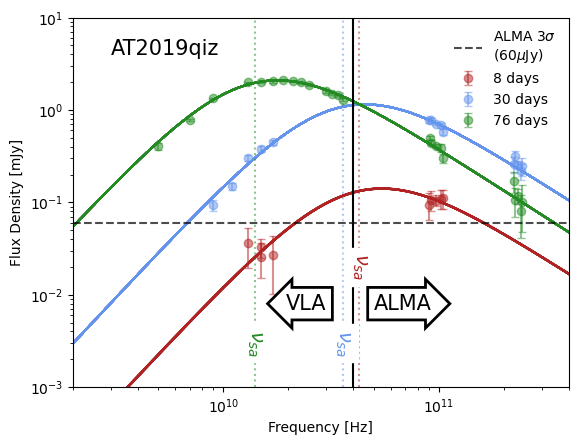

In [7]:
centervals = [8, 30, 76]
tols = [5, 5, 5]
locs = [2e-2, 3e-3, 3e-3]
theta_inits = [1, 10]
n = 1000
burnin = n//2
model = CustomB5_qiz #syncfit.models.B5
nkeep = 100
cols = ['firebrick', 'cornflowerblue', 'forestgreen']
p = 4

fig, ax = plt.subplots()

for val, tol, c, loc in zip(centervals, tols, cols, locs):

    ds = data[np.isclose(data.t, val, atol=tol)]

    lines = ax.errorbar(1e9*ds.Frequency, ds.FluxDensity, fmt='o', yerr=ds.FluxDensityErr, 
                label=f'{val} days', alpha=0.5, capsize=3, color=c)
    
    # with mm data
    sampler = syncfit.do_emcee(theta_inits, ds.Frequency.astype(float), ds.FluxDensity*1e3, 
                                ds.FluxDensityErr*1e3, plot=False, niter=n, model=model, fix_p=p)

    out, log_prob = syncfit.analysis.extract_output(sampler)
    nus = np.arange(1e8,5e12,1e7)  
    sed = model.SED
    best = out[np.argsort(log_prob)[-nkeep:]]
    cc = lines[-1][0].get_color()
    for o in best:
        res = sed(nus, p, *o)
        ax.plot(nus, res, alpha=0.1, linestyle='-', color=cc)

    nu_a = 10**syncfit.analysis.get_bounds(sampler, labels=['p', 'log F_v', 'log nu_a'],
                                           discard=n//2)[0][-1]

    ax.axvline(nu_a, linestyle=':', color=cc)
    ax.text(nu_a, loc, r'$\nu_{sa}$', fontsize=14, color=cc, ha='center', va='center',
            rotation=-90, alpha=1, backgroundcolor='w')
    
ax.set_ylabel(r'Flux Density [mJy]')
ax.set_xlabel('Frequency [Hz]')
ax.set_yscale('log')
ax.set_xscale('log')
ax.text(3e9, 4, 'AT2019qiz', fontsize=15, backgroundcolor='w')
ax.set_ylim(1e-3, 1e1)
ax.set_xlim(2e9, 4e11)

ax.axvline(40e9, color='k', linestyle='-')
ax.text(30e9, 8e-3, "VLA",
        ha="right", va="center", rotation=0, size=15,
        bbox=dict(boxstyle="larrow,pad=0.3", lw=2, fc='w', ec='k')
       )
ax.text(50e9, 8e-3, "ALMA",
        ha="left", va="center", rotation=0, size=15,
        bbox=dict(boxstyle="rarrow,pad=0.3", lw=2, fc='w', ec='k')
       )

ax.axhline(60e-3, linestyle='--', color='k', alpha=0.7, label='ALMA 3$\sigma$ \n(60$\mu$Jy)')

ax.legend(loc='upper right', frameon=False)

fig.savefig('2019qiz-sed-plot.png', transparent=False, bbox_inches='tight')